# NBA Predictions Model Testing and Evaluation 

### Team Members

Bryce

John

Mervin

Michael

Archie

## Background

Basketball, and the professional league run by the NBA, is the second most popular sport in the United States. According to Forbes, regular season NBA games average 1.4 million to 1.5 million viewers per game, with playoff games averaging 5.4 million viewers per game, and peaking at 11.65 million for the finals. Parallel to this, the sports betting industry has exploded since the historic ruling in Murphy v. NCAA, which opened up the possibility of state-regulated sports betting. As of 2023, sports betting is legal in 37 states and the District of Columbia. In 2022 alone, more than \\$93 billion in legal bets were placed in the US. Estimates for the total amount of legal bets placed on the NBA range from \\$10-20 billion.

Sports betting for the NBA takes three primary forms: betting on the winner of a game, the total number of points scored in a game, or betting on what is called “The Spread”. Odds for betting on the winner are given as either a numerical multiplier for the bettor’s return, or in terms of returns in \\$100 increments. For example, a bet could be at 1.25 odds, meaning that the return is \\$25 for a bet of \\$100. Or the bet could be placed at \\$130, meaning that the bettor would need to wager \\$130 to win \\$100. For the Spread, the bettor places a stake on a positive or negative number representing a difference between the final scores of the competing teams. If a team’s value is negative, the team would need to win by more than the negative value to win the bet. If the value is positive, the team would need to lose by less than the value or win the game.

## Introduction

Our team has opted to use a deep learning modelling approach to predict the winning and losing teams, as well as the difference between the team scores. Through our exploratory analysis and model testing, we arrived on a set of features and preprocessing protocols to train a model on. The features we used cast a wide net: using a rolling average of team stats across a season, individual player performance stats, and the arena itself.

The specifics of how bookmakers set their odds are closely guarded secrets – bookmakers consider a variety of factors ranging from past performance to home court advantage when setting their odds. Trying to predict the outcome of a sporting event isn’t novel or new, even with the advent of machine learning. However, robust prediction algorithms are not accessible for individuals, and require specialized skills to build, train, and maintain.

Our end goal is to provide AI-backed insights into the outcomes of NBA sporting events to anyone. We believe that giving users access to the predictive power of machine learning can help enthusiasts, analysts, pundits, and casual observers better understand a single game and how it fits into the season as a whole. Armed with this knowledge, they can then make predictions with greater confidence – on or off the books.


## Data Loading and Preprocessing functions 

In [1]:
import pandas as pd 
import numpy as np 
from os import listdir as ls
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import copy
import seaborn as sns
import keras
from keras import layers
from sklearn.impute import SimpleImputer
from IPython.display import Image
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [2]:
#pre processing functions 
class OneHotEncoder:
    def __init__(self, categories):
        self.categories = categories
        self.category_to_index = {category: i for i, category in enumerate(categories)}
        self.num_categories = len(categories)

    def encode(self, category):
        if category not in self.category_to_index:
            raise ValueError(f"Category '{category}' not found in the provided categories.")
        else:
            encoded_vector = np.zeros(self.num_categories, dtype=np.float32)
            encoded_vector[self.category_to_index[category]] = 1
            return encoded_vector
            
def get_top_n_pers(seasons_pers, n): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in seasons_pers['season'].unique():
        subset = seasons_pers[seasons_pers['season'] == season]
        roster_pers[season] = {}
        for team in teams:
            team_subset = subset[subset['team_id'] ==  team]
            team_subset = team_subset.sort_values(by='per', ascending=False)
            roster_pers[season][team] = np.float32(team_subset['per'].iloc[:n]).flatten()
    return roster_pers

def get_p_stat(data, n, stat): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in data['season'].unique():
        subset = data[data['season'] == season]
        roster_pers[season] = {}
        for team in teams_roster:
            team_subset = subset[subset['Tm'] ==  team]
            team_subset = team_subset.sort_values(by=stat, ascending=False)
            roster_pers[season][team] = team_subset[stat].iloc[:n]
    return roster_pers


def get_season(season_string):
    cleaned_reg_season = season_reg.copy()
    columns = season_reg.columns
    date_features = ['date']
    string_features = [ 'home_team', 'away_team', 'arena']
    numeric_features = [ c for c in columns if c not in string_features + date_features]
    cleaned_reg_season[numeric_features] = cleaned_reg_season[numeric_features].apply(pd.to_numeric)
    cleaned_reg_season[date_features] = cleaned_reg_season[date_features].apply(pd.to_datetime)
    start_date, end_date = f'20{season_string[2:4]}-10',  f'20{season_string[-2:]}-05'
    season = cleaned_reg_season[(cleaned_reg_season["date"] >= start_date) & (cleaned_reg_season["date"] <= end_date)]
    
    return season
    
def get_past_season(season_name):
    start = int(season_name[0:4])-1
    end = int(season_name[-2:])-1
    prior_season_name = f'{start}-{end}'
    return prior_season_name

def get_team_avgs(season_name, subset = True):
    prior_season_name = get_past_season(season_name)
    season = get_season(prior_season_name)
    # GET TEAM AVG OF THE WHOLE PAST SEASON 
    team_avg_p ={}
    if subset == True:
        home_stats_list  = ['home_team',  'home_fga', 'home_fg_pct',  'home_fg3a', 'home_fg3_pct',  'home_fta', 'home_ft_pct',
                        'home_orb', 'home_drb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf', 'home_pts']# remove home_pts if accuracy is bad  
        away_stats_list = ['away_team',  'away_fga', 'away_fg_pct',  'away_fg3a', 'away_fg3_pct', 'away_fta', 'away_ft_pct', 
                        'away_orb', 'away_drb',  'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf', 'away_pts']
    else:
        home_stats_list  = ['home_team', 'home_fg', 'home_fga', 'home_fg_pct', 'home_fg3', 'home_fg3a', 'home_fg3_pct', 'home_ft', 'home_fta', 'home_ft_pct',
                            'home_orb', 'home_drb', 'home_trb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf']
        away_stats_list = ['away_team', 'away_fg', 'away_fga', 'away_fg_pct', 'away_fg3', 'away_fg3a', 'away_fg3_pct', 'away_ft', 'away_fta', 'away_ft_pct', 
                        'away_orb', 'away_drb', 'away_trb', 'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf', 'away_pts']
    count = {}
    for index, row in season.iterrows():
        home, away = [0]*len(home_stats_list), [0]*len(away_stats_list)
        home_stats, away_stats = row[home_stats_list].tolist(), row[away_stats_list].tolist()
        
        if home_stats[0] in team_avg_p.keys():
            team_avg_p[home_stats[0]]= [round(x + y, 2) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]] +=1
        else:
            team_avg_p[home_stats[0]] = home_stats[1:]   
            count[home_stats[0]] =1
        if away_stats[0] in team_avg_p.keys():
            team_avg_p[away_stats[0]]= [round(x + y, 2) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]] +=1
        else:
            team_avg_p[away_stats[0]] = away_stats[1:]
            count[away_stats[0]] =1
    
    for team in teams:
        team_avg_p[team] = [x / count[team] for x in team_avg_p[team]] 
        
    #GET ROLLING AVG FOR TEAMS USING EACH GAME OF CURRENT SEASON 
    season = get_season(season_name)
    count = {}
    home_pcol, away_pcol = [], []
    for index, row in season.iterrows():
        home, away = [0]*len(home_stats_list), [0]*len(away_stats_list)
        home_stats, away_stats = row[home_stats_list].tolist(), row[away_stats_list].tolist()
        #current season averages 
        if home_stats[0] not in count.keys():  
            home_pcol.append(team_avg_p[home_stats[0]])
            team_avg_p[home_stats[0]]= [(x + y) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]] = 2
        else:
            home_pcol.append([x/count[home_stats[0]] for x in team_avg_p[home_stats[0]]])
            team_avg_p[home_stats[0]]= [(x + y) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]]+=1
        if away_stats[0] not in count.keys():  
            away_pcol.append(team_avg_p[away_stats[0]])
            team_avg_p[away_stats[0]]= [(x + y) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]] = 2
        else:
            away_pcol.append([x/count[away_stats[0]] for x in team_avg_p[away_stats[0]]])
            team_avg_p[away_stats[0]]= [(x + y) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]]+=1
    home_pcol = [np.array(sublist) for sublist in home_pcol]
    away_pcol = [np.array(sublist) for sublist in away_pcol]
    return home_pcol, away_pcol 

def pre_process(season, top_n, subset = True):
    season_name = season
    season = get_season(season)
    # shuffles data
    # season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    nc_home, nc_away = get_team_avgs(season_name, subset)
    # get one hot encodings and player stats 
    home_team, home_pers = [], []
    away_team, away_pers = [], []
    arena, winner = [], []
    row_stats = {}
    for stat in list(player_stats.keys()):
        row_stats["home_"+stat+"_input"] = []
        row_stats["away_"+stat+"_input"] = []

    for index, row in alt_season.iterrows():       
        home_team.append(team_encoder.encode(row.iloc[0]))
        away_team.append(team_encoder.encode(row.iloc[1]))
        arena.append(arena_encoder.encode(row.iloc[2]))
        winner.append(team_encoder.encode(row.iloc[3]))
        # get top n player stats
        if season_name == '2014-15':
            raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
        else: 
            prior_season_name = get_past_season(season_name)
            home_pers.append(rosters[prior_season_name][row.iloc[0]])
            away_pers.append(rosters[prior_season_name][row.iloc[1]])
        for stat in list(player_stats.keys()):
            row_stats["home_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[0]])
            row_stats["away_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[1]])
    # add non player stat data
    row_stats["home_pers_input"] = home_pers
    row_stats["away_pers_input"] = away_pers
    row_stats["home_team_input"] = home_team
    row_stats["away_team_input"] = away_team
    row_stats["home_avg_stats_input"] = nc_home
    row_stats["away_avg_stats_input"] = nc_away
    row_stats["arena_input"] = arena

    #convert to tensors 
    for item in row_stats.keys():
        row_stats[item] = tf.convert_to_tensor(row_stats[item])
        
    return row_stats,  {"spread": spread, "outcome": tf.convert_to_tensor(winner)}

def pre_process_binary(season, top_n, subset = True):
    season_name = season
    season = get_season(season)
    # shuffles data
    # season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, 1, 0)
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    nc_home, nc_away = get_team_avgs(season_name, subset)
    # get one hot encodings and player stats 
    home_team, home_pers = [], []
    away_team, away_pers = [], []
    arena, winner = [], []
    row_stats = {}
    for stat in list(player_stats.keys()):
        row_stats["home_"+stat+"_input"] = []
        row_stats["away_"+stat+"_input"] = []
    for index, row in alt_season.iterrows():       
        home_team.append(team_encoder.encode(row.iloc[0]))
        away_team.append(team_encoder.encode(row.iloc[1]))
        arena.append(arena_encoder.encode(row.iloc[2]))
        if row.iloc[3] == 1:
            winner.append([1, 0])
        else:
            winner.append([0, 1])
        # get top n player stats
        if season_name == '2014-15':
            raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
        else: 
            prior_season_name = get_past_season(season_name)
        home_pers.append(rosters[prior_season_name][row.iloc[0]])
        away_pers.append(rosters[prior_season_name][row.iloc[1]])
        for stat in list(player_stats.keys()):
            row_stats["home_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[0]])
            row_stats["away_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[1]])
    # add non player stat data
    row_stats["home_pers_input"] = home_pers
    row_stats["away_pers_input"] = away_pers
    row_stats["home_team_input"] = home_team
    row_stats["away_team_input"] = away_team
    row_stats["home_avg_stats_input"] = nc_home
    row_stats["away_avg_stats_input"] = nc_away
    row_stats["arena_input"] = arena
    
    
   
    for item in row_stats.keys():
        row_stats[item] = tf.convert_to_tensor(row_stats[item])

    row_targets = {"spread": np.clip(spread, -20, 20), "outcome": tf.convert_to_tensor(winner)}

    return row_stats,  row_targets

def build_lasso_model(x_dict, y_dict, model_name=None, layers=None, activation_function=None, show_summary=False, l1_val= 0.01):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    concat_input= []
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        if input == "home_avg_stats_input":
            # create l1 reg 
            home_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(l1_val))(input_dict[input])
            concat_input.append(home_avg_stats_input_d )
            l1+=x_dict[input].shape[1]
        elif input == "away_avg_stats_input":
            # create l1 reg 
            away_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(l1_val))(input_dict[input])
            concat_input.append(away_avg_stats_input_d)
            l1+=x_dict[input].shape[1]

        else:
            l1+=x_dict[input].shape[1]
            concat_input.append(input_dict[input])
        
    concatenated_inputs = tf.keras.layers.concatenate(concat_input)
    layers = [l1]+layers
    last_h_layer = None
    for i in range(len(layers)):
        units = layers[i]
        if i==0:
            prev_layer = tf.keras.layers.Dense(units, activation=activation_function)(concatenated_inputs)
        elif i == len(layers)-1:
            last_h_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
        else:
            prev_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
    
    concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], last_h_layer, input_dict['away_team_input']])
    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':bce_loss}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

def build_model_two(x_dict, y_dict, model_name=None, layers=None, activation_function=None, show_summary=False):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        l1+=x_dict[input].shape[1]
        
    concatenated_inputs = tf.keras.layers.concatenate([input_dict[x] for x in list(input_dict.keys())])
    layers = [l1]+layers
    last_h_layer = None
    for i in range(len(layers)):
        units = layers[i]
        if i==0:
            prev_layer = tf.keras.layers.Dense(l1, activation=activation_function)(concatenated_inputs)
        elif i == len(layers)-1:
            last_h_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
        else:
            prev_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
    
    concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], last_h_layer, input_dict['away_team_input']])
    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':bce_loss}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

def calculate_accuracy(true_labels, predicted_labels):
    # Convert arrays to numpy arrays if they are not already
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    # Count the number of correct predictions
    correct_predictions = np.sum(true_labels == predicted_labels)
    
    # Calculate the total number of predictions
    total_predictions = len(true_labels)
    
    # Calculate the accuracy
    accuracy = correct_predictions / total_predictions
    
    return accuracy
    
def build_model_do(x_dict, y_dict, do_rate, do_layers, model_name=None, layers=None, activation_function=None, show_summary=False):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    concat_input= []
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        if input == "home_avg_stats_input":
            # create l1 reg 
            home_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(home_avg_stats_input_d )
            l1+=x_dict[input].shape[1]
        elif input == "away_avg_stats_input":
            # create l1 reg 
            away_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(away_avg_stats_input_d)
            l1+=x_dict[input].shape[1]

        else:
            l1+=x_dict[input].shape[1]
            concat_input.append(input_dict[input])
        
    concatenated_inputs = tf.keras.layers.concatenate(concat_input)
    layers = [l1]+layers
    
    h1 = tf.keras.layers.Dense(layers[0], activation=activation_function)(concatenated_inputs)
    
    if do_layers[0] == 1:
        h1_d = tf.keras.layers.Dropout(do_rate)(h1)
        h2 = tf.keras.layers.Dense(layers[1], activation=activation_function)(h1_d)
    else:
        h2 = tf.keras.layers.Dense(layers[1], activation=activation_function)(h1)
        
    if do_layers[1] == 1:
        h2_d = tf.keras.layers.Dropout(do_rate)(h2)
        h3 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h2_d)
    else:
        h3 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h2)
        
    if do_layers[2] == 1:
        h3_d = tf.keras.layers.Dropout(do_rate)(h3)
        h4 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h3_d)
    else:
        h4 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h3)
        
    if do_layers[3] == 1:
        h4_d = tf.keras.layers.Dropout(do_rate)(h4)
        h5 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h4_d)
    else:
        h5 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h4)
        
    if do_layers[4] == 1:
        h5_d = tf.keras.layers.Dropout(do_rate)(h5)
        concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5_d, input_dict['away_team_input']])
    else:
        concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5, input_dict['away_team_input']])
    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':bce_loss}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

def generate_combinations(array):
    def generate_helper(index, current_combination):
        if index == len(array):
            combinations.append(current_combination)
            return
        generate_helper(index + 1, current_combination + [0])
        generate_helper(index + 1, current_combination + [1])

    combinations = []
    generate_helper(0, [])
    return combinations

def build_model_bn(x_dict, y_dict, do_rate, do_layers, bn_layers, model_name=None, layers=None, activation_function=None, show_summary=False):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    concat_input= []
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        if input == "home_avg_stats_input":
            # create l1 reg 
            home_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(home_avg_stats_input_d )
            l1+=x_dict[input].shape[1]
        elif input == "away_avg_stats_input":
            # create l1 reg 
            away_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(away_avg_stats_input_d)
            l1+=x_dict[input].shape[1]

        else:
            l1+=x_dict[input].shape[1]
            concat_input.append(input_dict[input])
        
    concatenated_inputs = tf.keras.layers.concatenate(concat_input)
    layers = [l1]+layers
    
    h1 = tf.keras.layers.Dense(layers[0], activation=activation_function)(concatenated_inputs)

    if bn_layers[0] == 1:
        h1_bn = tf.keras.layers.BatchNormalization()(h1)
        h2 = tf.keras.layers.Dense(layers[1], activation=activation_function)(h1_bn)
    else:
        h2 = tf.keras.layers.Dense(layers[1], activation=activation_function)(h1)
        
    if bn_layers[1] == 1:
        h2_bn = tf.keras.layers.BatchNormalization()(h2)
        h3 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h2_bn)
    else:
        h3 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h2)
    
    if bn_layers[2] == 1:
        h3_bn = tf.keras.layers.BatchNormalization()(h3)
        h4 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h3_bn)
    else:
        h4 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h3)
    
    if bn_layers[3] == 1:
        h4_bn = tf.keras.layers.BatchNormalization()(h4)
        h5 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h4_bn)
    else:
        h5 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h4)
    h5_d = tf.keras.layers.Dropout(do_rate)(h5)
    if bn_layers[4] == 1:
        h5_bn = tf.keras.layers.BatchNormalization()(h5_d)
        concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5_bn, input_dict['away_team_input']])
    else:
        concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5_d, input_dict['away_team_input']])

    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':bce_loss}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

def run_pca(prior_season='2019-20', imp=None, pca = None):
    advanced_stats = pd.read_csv("adv_stats_data.csv").drop(columns=['Unnamed: 0'])
    prior_season = advanced_stats[advanced_stats['season'] == prior_season]
    numeric_cols = prior_season.select_dtypes(include='number')
    
    if imp == None: # train 
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        numeric_cols = imp.fit_transform(numeric_cols)
        # Fit PCA
        pca = PCA(5)
        pca_data = pd.DataFrame(pca.fit_transform(numeric_cols))
        pca_data['season'] = prior_season['season'].values
        pca_data['Tm'] = prior_season['Tm'].values
        
        return pca_data, pca, imp
        
    else: # test 
        numeric_cols = imp.transform(numeric_cols)
        pca_data = pd.DataFrame(pca.transform(numeric_cols))
        pca_data['season'] = prior_season['season'].values
        pca_data['Tm'] = prior_season['Tm'].values
        return pd.DataFrame(pca_data), pca, imp

    # # Calculate cumulative explained variance ratio
    # cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # print(cumulative_variance_ratio)
    # # Plot cumulative explained variance ratio
    # plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
    # plt.xlabel('Number of Components')
    # plt.ylabel('Cumulative Explained Variance Ratio')
    # plt.title('Cumulative Explained Variance Ratio by Number of Components')
    # plt.grid(True)
    # plt.show()
    # 5 seems to be good here explains 99%+ of the variance


def pre_process_pca_binary(season, top_n, subset = True, pca = None, imp = None):
    season_name = season
    season = get_season(season_name)
    # shuffles data
    # season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, 1, 0)
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    nc_home, nc_away = get_team_avgs(season_name, subset)
    # get one hot encodings and player stats 
    home_team, home_pers = [], []
    away_team, away_pers = [], []
    arena, winner = [], []
    row_stats = {}
    #pca player_stats 
    prior_season_name = get_past_season(season_name)
    try:
        pca_data, pca, imp = run_pca(prior_season_name, imp, pca)
    except:
        pca_data, pca, imp = run_pca(prior_season_name, imp=None, pca = None)
        
    player_stats ={}
    
    for stat in pca_data.columns:
        # create variable for top stat dict ex. rosters_dbpm = get_p_stat(adv_stats, 8, "DBPM"
        player_stats[str(stat)] = get_p_stat_pca(pca_data, 8, stat)
    del player_stats['season']
    del player_stats['Tm']
    for stat in list(player_stats.keys()):
        if stat != "season"  and stat != "season":
            row_stats["home_"+stat+"_input"] = []
            row_stats["away_"+stat+"_input"] = []
    for index, row in alt_season.iterrows():       
        home_team.append(team_encoder.encode(row.iloc[0]))
        away_team.append(team_encoder.encode(row.iloc[1]))
        arena.append(arena_encoder.encode(row.iloc[2]))
        if row.iloc[3] == 1:
            winner.append([1, 0])
        else:
            winner.append([0, 1])
        # get top n player stats
        if season_name == '2014-15':
            raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
        else: 
            prior_season_name = get_past_season(season_name)
        home_pers.append(rosters[prior_season_name][row.iloc[0]])
        away_pers.append(rosters[prior_season_name][row.iloc[1]])
        for stat in list(player_stats.keys()):
            row_stats["home_"+stat+"_input"].append(player_stats[stat][row.iloc[0]])
            row_stats["away_"+stat+"_input"].append(player_stats[stat][row.iloc[1]])
    # add non player stat data
    row_stats["home_pers_input"] = home_pers
    row_stats["away_pers_input"] = away_pers
    row_stats["home_team_input"] = home_team
    row_stats["away_team_input"] = away_team
    row_stats["home_avg_stats_input"] = nc_home
    row_stats["away_avg_stats_input"] = nc_away
    row_stats["arena_input"] = arena
    for item in row_stats.keys():
        row_stats[item] = tf.convert_to_tensor(row_stats[item])
    row_targets = {"spread": np.clip(spread, -20, 20), "outcome": tf.convert_to_tensor(winner)}

    return row_stats,  row_targets, pca, imp 

def get_p_stat_pca(data, n, stat):
    roster_pers = {}
    for team in teams_roster:
        team_subset = data[data['Tm'] ==  team]
        team_subset = team_subset[[stat]].sort_values(by=stat, ascending=False).iloc[:n].values
        roster_pers[team] = team_subset
    return roster_pers


# def get_p_stat(data, n, stat): # can adjust to get pers of past seasonm on the new seasons roster
#     roster_pers = {}
#     for season in data['season'].unique():
#         subset = data[data['season'] == season]
#         roster_pers[season] = {}
#         for team in teams_roster:
#             team_subset = subset[subset['Tm'] ==  team]
#             team_subset = team_subset.sort_values(by=stat, ascending=False)
#             roster_pers[season][team] = team_subset[stat].iloc[:n]

## Preprocessing

To obtain the data for our project, we scraped the basketball-reference.com website to collect team and player-level game statistics, team rosters for each season, as well as a history of regular season NBA games and their outcomes from the 2015 NBA season up to the 2024 NBA season. 

The team-level game statistics were converted from being statistics about the specific matchup to being a rolling average of the team's statistics prior to that matchup. For each team's first regular season game, the rolling average of each stat was calculated by averaging that stat for each of the games the team played during the prior season. Subsequent games were averaged with the team's performance from the previous season to create an evolving picture of each team's performance leading up to that game. This rolling average approach allowed us to capture the team's recent form and performance trends, providing valuable insights for our analysis. 

Additionally, player-level statistics were aggregated based on their team to help capture the effect of individual players on the scores and outcome of a game. By combining these datasets, we aimed to build a comprehensive yet focused foundation for our predictive modeling and analysis of NBA game outcomes.



In [3]:
season_reg = pd.read_csv('combined_game_stats.csv') #2014-15 - 2022-23 regular_season matches 
seasons_pers = pd.read_csv('player_ERs.csv') #2014-15 - 2022-23 player eficiency ratings
adv_stats = pd.read_csv("adv_stats_data.csv")
adv_stats = adv_stats.drop(['Unnamed: 0'], axis = 1)
adv_stats.rename(columns={'WS/48': 'win_shares_48'}, inplace=True)
teams = season_reg['home_team'].unique()
arenas = season_reg['arena'].unique()
teams_roster = adv_stats["Tm"].unique()
team_encoder = OneHotEncoder(teams)
arena_encoder = OneHotEncoder(arenas)
rosters = get_top_n_pers(seasons_pers, 8)  # rosters[season][team]

player_stats ={}
for stat in adv_stats:
    # create variable for top stat dict ex. rosters_dbpm = get_p_stat(adv_stats, 8, "DBPM"
    if stat != 'Tm' and stat != 'season':
        player_stats[stat] = get_p_stat(adv_stats, 8, stat)

## Establishing a baseline and Goals for metrics 

In [4]:
x_train, y_train= pre_process_binary('2016-17', top_n=8, subset = False)
x_test, y_test= pre_process_binary('2017-18',top_n=8, subset = True)
# len(x_train['home_team_input']) 1230

In [5]:
unique_elements, counts = np.unique(y_test["spread"], return_counts=True)
print("baseline spread accuracy: ", max(counts)/sum(counts) )
unique_elements, counts = np.unique(np.argmax(y_test["outcome"], axis=1), return_counts=True)
print("baseline outcome accuracy: ", max(counts)/sum(counts) )
# baseline is 5% anythong better is better than random guessing!

baseline spread accuracy:  0.08536585365853659
baseline outcome accuracy:  0.5788617886178862


## Baselines 
- A sucessful model should be able to correctly pick the winning team from a matchup with more than 59% of the time.
- A sucessful model should be able to correctly predict the spread of a game more than 12% of the time.

# Feature Selection 

## Experiment 1 - Do Game Stats Improve Predicition Accuracy?

In [6]:
home_keys = [key for key in x_train if 'home' in key and key != 'home_team_input' and key != 'home_avg_stats_input']
away_keys = [key for key in x_train if 'away' in key and key != 'away_team_input' and key != 'away_avg_stats_input']
core_stats = [key for key in x_train if key not in home_keys and key not in away_keys]
min_stats = ['home_team_input','away_team_input', 'arena_input']
main_v_core = [min_stats, core_stats]

final loss = 81.87344360351562, final validation_loss = 111.72176361083984  -model_index:0
final outcome accuracy = 0.5537488460540771, final validation_accuracy = 0.5528455376625061  -model_index:0
final spread mse = 80.74159240722656, final validation_mse = 111.06302642822266  -model_index:0



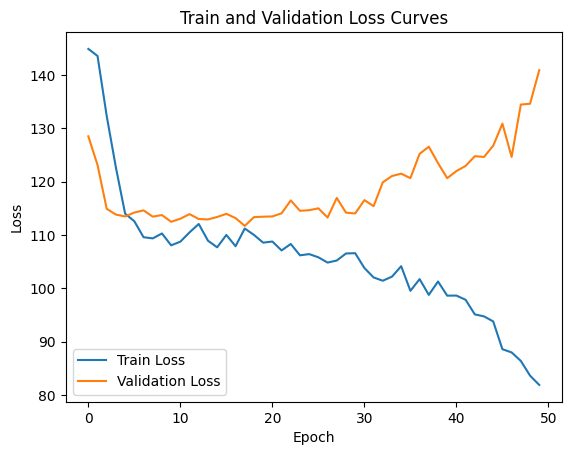

final loss = 109.75692749023438, final validation_loss = 112.9777603149414  -model_index:1
final outcome accuracy = 0.48961156606674194, final validation_accuracy = 0.5121951103210449  -model_index:1
final spread mse = 108.64728546142578, final validation_mse = 112.32469177246094  -model_index:1



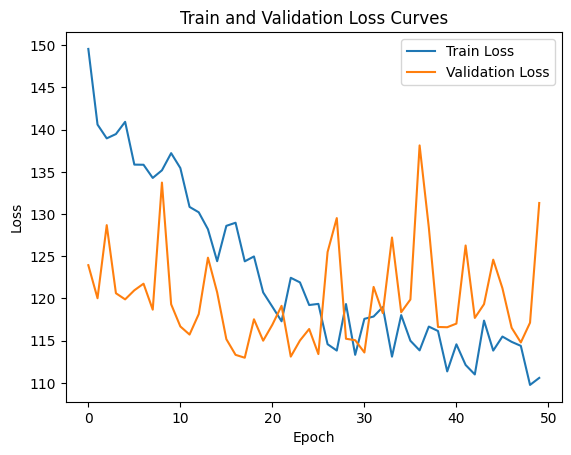

In [7]:
index = 0 
for inputs in main_v_core:
    train_data= {}
    l1 = 0
    for input in inputs:
        train_data[input] = x_train[input]
        l1+=x_train[input].shape[1]
    model = build_model_two(train_data, y_train, model_name = f"model_index:{str(index)}", layers = [l1, l1, l1, l1], activation_function="gelu", show_summary = False)
    history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=150, validation_split = 0.10, verbose = 0)
    cur_loss = min(history.history['val_loss'])
    cur_acc = max(history.history['val_outcome_accuracy'])
    # if cur_loss < lead_val_loss:    
    #     print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}", f" -model_index:{str(index)}")
    # if cur_acc >lead_val_acc:   
    #     print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}", f" -model_index:{str(index)}")
    # print()
      
    print(f"final loss = {min(history.history['loss'])}, final validation_loss = {min(history.history['val_loss'])}", f" -model_index:{str(index)}")
    print(f"final outcome accuracy = {min(history.history['outcome_accuracy'])}, final validation_accuracy = {min(history.history['val_outcome_accuracy'])}", f" -model_index:{str(index)}")
    print(f"final spread mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}", f" -model_index:{str(index)}")
    print()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    index+=1 

In [8]:
x_train, y_train= pre_process_binary('2016-17', top_n=8, subset = True)

final loss = 128.93167114257812, final validation_loss = 108.36939239501953  -model_index:2
final outcome accuracy = 0.47786810994148254, final validation_accuracy = 0.38211381435394287  -model_index:2
final spread mse = 127.37196350097656, final validation_mse = 107.6634750366211  -model_index:2



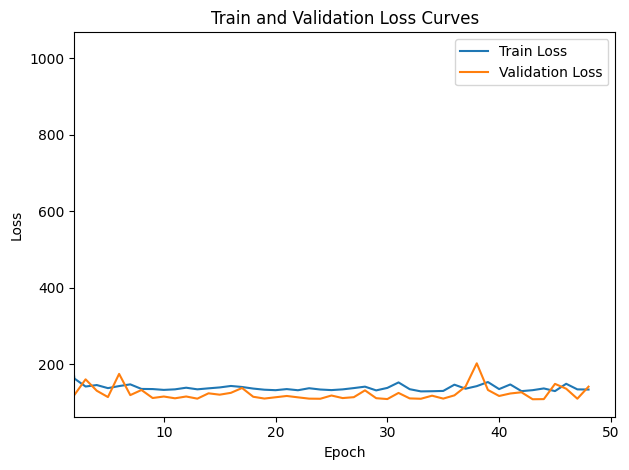

In [9]:
l1 = 0
for input in x_train:
    train_data[input] = x_train[input]
    l1+=x_train[input].shape[1]
model = build_model_two(train_data, y_train, model_name = f"model_index:{str(index)}", layers = [l1, l1, l1, l1], activation_function="gelu", show_summary = False)
history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=150, validation_split = 0.10, verbose = 0)
cur_loss = min(history.history['val_loss'])
cur_acc = max(history.history['val_outcome_accuracy'])
print(f"final loss = {min(history.history['loss'])}, final validation_loss = {min(history.history['val_loss'])}", f" -model_index:{str(index)}")
print(f"final outcome accuracy = {min(history.history['outcome_accuracy'])}, final validation_accuracy = {min(history.history['val_outcome_accuracy'])}", f" -model_index:{str(index)}")
print(f"final spread mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}", f" -model_index:{str(index)}")
print()
plt.plot(history.history['loss'][1:], label='Train Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.title('Train and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(left=2)  # Set the left limit of x-axis to 5
plt.tight_layout()
plt.legend()
plt.show()
index+=1 

Since we discovered that here were high correlations between many team level stats and this would negatively affect the performance of our model we wanted heavily explore feature selection in our approach. 

Our first experiment focused on the effect of the game level statistics on the loss of the model. Three models were trained to determine if and to what extent team-level game statistics should be incorporated in the model.
- *Model 1* - a model that used a one hot encoding of each of the teams in the matchup and a one hot encoding of the arena hosting the match 
- *Model 2* - a model that used all of the team level game statistics<sup> 1 </sup>. 
- *Model 3* - a model using a reduced version of the team level game statistics based on our Exploratory Data Analysis<sup> 2 </sup>. 

These models had two outputs an integer representing the predicted spread, and a categorical output to predict whether the home team would win or lose the match and 10% of the dataset, 123 games, from the end of the season were used as a validation set. Of the three models the first model, using only the teams in a matchup and the arena the match was held, achieved the highest accuracy on the validation set (52.8%) when predicting whether the home team would win or lose a matchup. This model had a validation loss of 130, a validation mean squarred error (mse) of 108 for spread predictions, and showed signs of overfitting as the train and validation loss curves steadily diverged with increasing epochs of training. 

The second model had a slightly lower validation loss of 126 but performed worse than the first model for both metrics with a validation accuracy of 41% for outcome prediction and a mse of 112 for spread predictions on the validation set. This model also showed signs of overfitting but at a much smaller scale than the first model. The third model using a subset of the team level game stats based on our exploratory data analysis had the lowest validation loss at 117, the lowest validation accuracy for predicting the outcome of a matchup at 40%, and lowest mean squarred error, 107.63, for spread predictions on the validation set. Despite the performance of the model for the two tasks, the inter-connectedness of the training and validation loss curves as well as their general downward trend suggest that subsequent experiments would be most sucessful using the subset of team-level game statistics.  

 
[1]: Game stats used by the model: home_team', 'home_fg', 'home_fga', 'home_fg_pct', 'home_fg3', 'home_fg3a', 'home_fg3_pct', 'home_ft', 'home_fta', 'home_ft_pct', 'home_orb', 'home_drb', 'home_trb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf', 'home_pts', 'away_team', 'away_fg', 'away_fga', 'away_fg_pct', 'away_fg3', 'away_fg3a', 'away_fg3_pct', 'away_ft', 'away_fta', 'away_ft_pct', 'away_orb', 'away_drb', 'away_trb', 'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf', 'away_pts', 'arena'.

[2]: Game stats subset used by the model: 'home_team',  'home_fga', 'home_fg_pct',  'home_fg3a', 'home_fg3_pct',  'home_fta', 'home_ft_pct', 'home_orb', 'home_drb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf', 'home_pts']

# Experiment 2 -- Does l1 Norm of the Game Stats Data Improve Results?

From season to season, team performance can vary dramatically -- either surpassing performance or being heavily impacted by an MVP-caliber performance. For this reason, over-fitting is one of our primary concerns for model results. L1 normalization is our first experient to assess how we can combat over-fitting.

final loss = 113.11488342285156, final validation_loss = 113.0026626586914  -model_index:3
final outcome accuracy = 0.5465221405029297, final validation_accuracy = 0.5203251838684082
final spread mse = 111.64769744873047, final validation_mse = 111.74186706542969


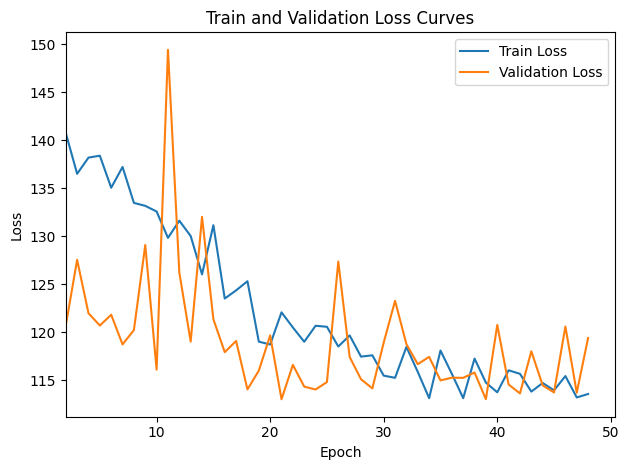

In [10]:
l1 = 0 
train_data= {}
for input in core_stats:
    train_data[input] = x_train[input]
    l1+=x_train[input].shape[1]
    
model = build_lasso_model(train_data, y_train, model_name = "core_stats", layers = [l1, l1, l1, l1], activation_function="gelu", show_summary = False, l1_val = 0.01)
history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=150, validation_split = 0.10, verbose = 0)
print(f"final loss = {min(history.history['loss'])}, final validation_loss = {min(history.history['val_loss'])}", f" -model_index:{str(index)}")
print(f"final outcome accuracy = {min(history.history['outcome_accuracy'])}, final validation_accuracy = {min(history.history['val_outcome_accuracy'])}")
print(f"final spread mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
plt.plot(history.history['loss'][1:], label='Train Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.title('Train and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(left=2)  # Set the left limit of x-axis to 5
plt.tight_layout()
plt.legend()
plt.show()


### Results

L1 normalization on the game statistics inputs lowers overfitting, having much closer results for training and validation accuracy.  It performed better in validation accuracy, gaining about 14 percent accuracy. The model performed slightly worse in regards to validation mse as it was slightly raised from the model without L1 normalization.  The L1 normalization model also performed worse in validation loss, being slightly higher than the model without L1 normalization.

## Experiment 3 -- Experimenting with Different Regularization Factors

Having seen the broad impacts of l1 normalization, we took a fine-tuned approach to see where it would best serve our model. We applied normalizations at different values, and in different layers of the model.

final loss = 108.3207015991211, final validation_loss = 110.29622650146484
final outcome accuracy = 0.5654923319816589, final validation_accuracy = 0.4878048896789551
final spread mse = 108.82896423339844, final validation_mse = 109.64391326904297

final loss = 110.61640167236328, final validation_loss = 112.49637603759766
final outcome accuracy = 0.5582655668258667, final validation_accuracy = 0.42276424169540405
final spread mse = 110.2042007446289, final validation_mse = 111.75262451171875

final loss = 108.58374786376953, final validation_loss = 112.7008285522461
final outcome accuracy = 0.5338753461837769, final validation_accuracy = 0.49593496322631836
final spread mse = 109.29878234863281, final validation_mse = 111.64849853515625

final loss = 99.98216247558594, final validation_loss = 115.47924041748047
final outcome accuracy = 0.5284552574157715, final validation_accuracy = 0.4796747863292694
final spread mse = 97.79914093017578, final validation_mse = 114.08917999267578

fin

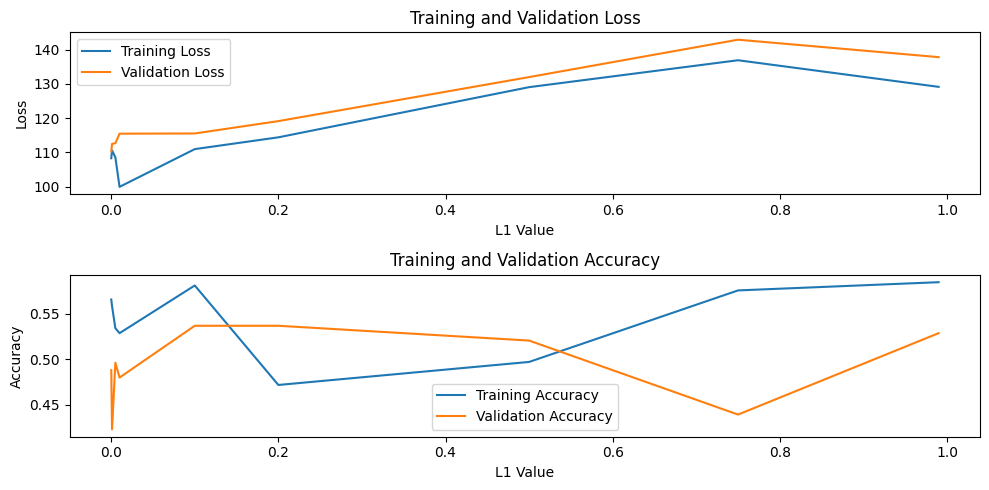

In [11]:
import matplotlib.pyplot as plt

l1 = 0 
train_data = {}
losses = []
val_losses = []
outcome_accuracies = []
val_outcome_accuracies = []
spread_mses = []
val_spread_mses = []

for input in core_stats:
    train_data[input] = x_train[input]
    l1 += x_train[input].shape[1]

l1_vals = [0.0001, 0.001, 0.005, 0.01, 0.1, 0.2, 0.5, 0.75, 0.99]
best_val = 0
best_loss = 1000

for l1_val in l1_vals:
    model = build_lasso_model(train_data, y_train, model_name="core_stats", layers=[l1, l1, l1, l1], activation_function="gelu", show_summary=False, l1_val=l1_val)
    history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=150, validation_split=0.10, verbose=0)
    
    loss = min(history.history['loss'])
    val_loss = min(history.history['val_loss'])
    outcome_accuracy = min(history.history['outcome_accuracy'])
    val_outcome_accuracy = min(history.history['val_outcome_accuracy'])
    spread_mse = min(history.history['spread_mean_squared_error'])
    val_spread_mse = min(history.history['val_spread_mean_squared_error'])
    
    losses.append(loss)
    val_losses.append(val_loss)
    outcome_accuracies.append(outcome_accuracy)
    val_outcome_accuracies.append(val_outcome_accuracy)
    spread_mses.append(spread_mse)
    val_spread_mses.append(val_spread_mse)
    
    print(f"final loss = {loss}, final validation_loss = {val_loss}")
    print(f"final outcome accuracy = {outcome_accuracy}, final validation_accuracy = {val_outcome_accuracy}")
    print(f"final spread mse = {spread_mse}, final validation_mse = {val_spread_mse}")
    print()
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_val = l1_val

print("best l1 val:", best_val)

# Plot the values
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(l1_vals, losses, label='Training Loss')
plt.plot(l1_vals, val_losses, label='Validation Loss')
plt.xlabel('L1 Value')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(l1_vals, outcome_accuracies, label='Training Accuracy')
plt.plot(l1_vals, val_outcome_accuracies, label='Validation Accuracy')
plt.xlabel('L1 Value')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Results

For our l1 normalization, our best performing score was 0.001. For this value, we saw minimal results for the training and testing accuracy and validation scores compared to the baseline value of 0.0. However, in combination with later experiments, l1 does make a significant contribution to reducing overfitting of the model, and improve generalization capabilities.

## Experiment 4 -- Do Player Stats Improve Model Performance for Either Spread Prediciton or Outcome Prediction?

Our team implemented a genetic algorithm to investigate. This algorithm builds a feature set from the advanced player stats by iteratively updating the advanced stats used to make predictions based on that features impact on the validation accuracy of the model. Similar to learning rate, the algorithm stops when additional features don't improve model performance.

In [12]:
def train_input_loop(best_train_data, home_keys, away_keys, lead_val_loss, i):
    global player_subset
    print(f"train_input_loop_{i+1}")
    new_btd ={}
    
    while home_keys != []:
        old_lead_val_accuracy = lead_val_loss
        l1 = 0
        for key in best_train_data.keys():
            l1+=best_train_data[key].shape[1]
        for key_idx in range(len(home_keys)):
            train_data= copy.deepcopy(best_train_data)
            # add stats being tested
            train_data[home_keys[key_idx]] = x_train[home_keys[key_idx]]
            train_data[away_keys[key_idx]] = x_train[away_keys[key_idx]]
      
            
            l1 += x_train[home_keys[key_idx]].shape[1]+ x_train[away_keys[key_idx]].shape[1]
            model = build_lasso_model(train_data, y_train, model_name="core_stats", layers=[l1, l1, l1, l1], activation_function="gelu", show_summary=False, l1_val=best_val)
            history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=150, validation_split = 0.1, verbose = 0)
            cur_val_loss = min(history.history['val_loss'])
            if cur_val_loss < lead_val_loss:
                lead_val_loss = cur_val_loss
                new_btd = copy.deepcopy(train_data)
                print("\n", train_data.keys())
                # player_subset = list(best_train_data.keys())
                model.save('efs_model.keras')
                print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
                print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
                print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
                plt.plot(history.history['loss'][1:], label='Train Loss')
                plt.plot(history.history['val_loss'][1:], label='Validation Loss')
                plt.title('Train and Validation Loss Curves')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()
                plt.savefig('train_input_loop.png')
                print()
                
            else:
                print(cur_val_loss, end =" ")
            l1 = 0
            for key in best_train_data.keys():
                l1+=best_train_data[key].shape[1]
                
    
        if old_lead_val_accuracy != lead_val_loss:
            home_keys_c = home_keys.copy()  # Make a copy to avoid modifying the original
            away_keys_c = away_keys.copy()  # Make a copy to avoid modifying the original
            print("best keys")
            print(new_btd.keys())
            
            

            for key in new_btd.keys():
                if key in home_keys_c:
                    home_keys_c.remove(key)
                elif key in away_keys_c:  # Fixing this condition
                    away_keys_c.remove(key)
            
            i = i+1
            return train_input_loop(new_btd, home_keys_c, away_keys_c, lead_val_loss, i)
        else:
            print("best model params above")
            return list(best_train_data.keys())

train_input_loop_1

 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_Age_input', 'away_Age_input'])
Best loss = 104.1865463256836, Best validation_loss = 111.08929443359375
Best accuracy = 0.6982836723327637, Best validation_accuracy = 0.6504064798355103
Best mse = 105.1663589477539, final validation_mse = 110.40382385253906


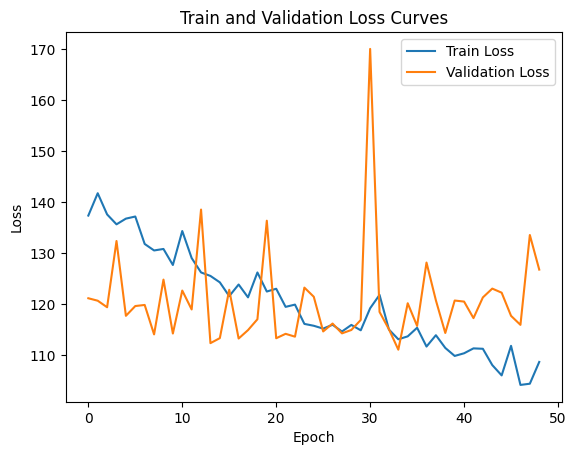


113.23552703857422 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_MP_input', 'away_MP_input'])
Best loss = 120.40111541748047, Best validation_loss = 108.32902526855469
Best accuracy = 0.586269199848175, Best validation_accuracy = 0.6585366129875183
Best mse = 121.2701416015625, final validation_mse = 106.8061752319336


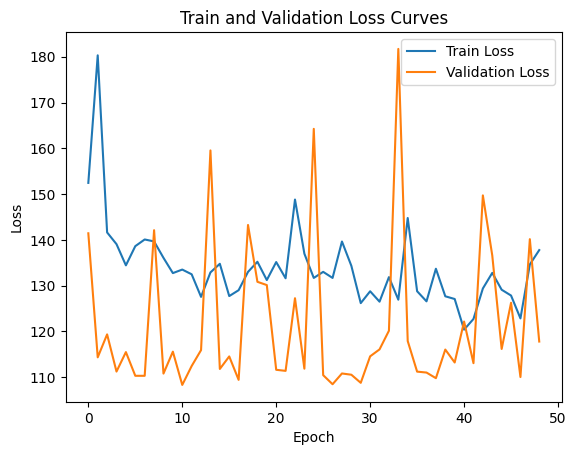


108.57989501953125 112.5831069946289 114.24966430664062 112.85359954833984 111.50517272949219 112.4090347290039 110.13774871826172 112.66165924072266 111.0680923461914 111.15608978271484 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_TOV%_input', 'away_TOV%_input'])
Best loss = 106.85023498535156, Best validation_loss = 107.05689239501953
Best accuracy = 0.695573627948761, Best validation_accuracy = 0.6504064798355103
Best mse = 105.72164154052734, final validation_mse = 106.40115356445312


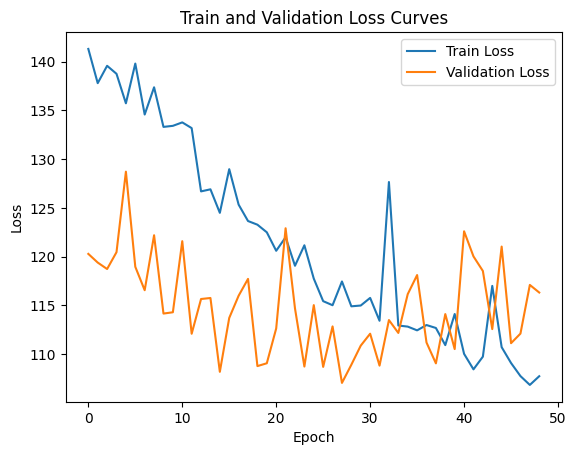


110.310791015625 108.80028533935547 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input'])
Best loss = 104.90125274658203, Best validation_loss = 103.81817626953125
Best accuracy = 0.6865401864051819, Best validation_accuracy = 0.6666666865348816
Best mse = 104.2582778930664, final validation_mse = 103.16136932373047


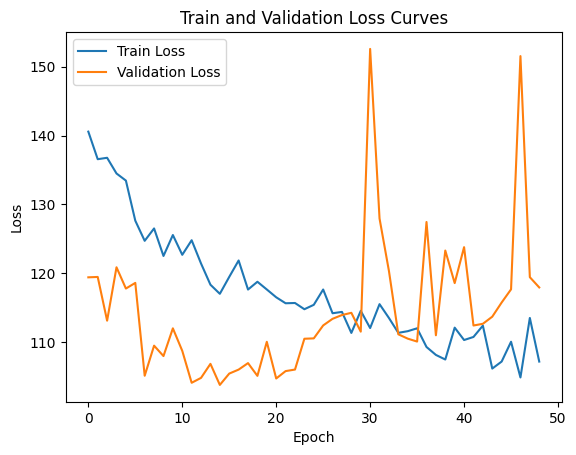


103.81957244873047 111.48127746582031 112.31765747070312 106.45173645019531 106.71166229248047 106.80281066894531 110.09896850585938 best keys
dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input'])
train_input_loop_2
106.5683364868164 107.24267578125 109.58413696289062 108.75988006591797 107.09076690673828 105.9391098022461 106.31929779052734 104.41519927978516 105.64678192138672 105.35798645019531 105.88446044921875 108.02352905273438 107.04507446289062 104.92121124267578 107.32469940185547 105.8377914428711 104.89130401611328 106.80216217041016 108.12374114990234 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_DBPM_input', 'away_DBPM_input'])
Best loss = 107.80406188964844, Best validation_loss = 102.05609893798828
Best accuracy = 0.6829268336296082, Best validation_accuracy = 0.66666

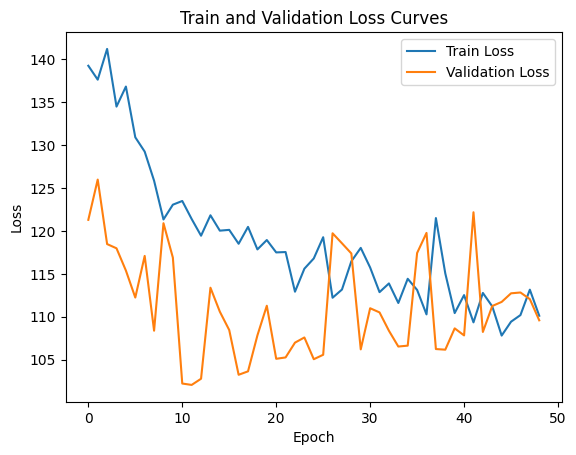



 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input'])
Best loss = 101.718994140625, Best validation_loss = 101.7986068725586
Best accuracy = 0.706413745880127, Best validation_accuracy = 0.6666666865348816
Best mse = 101.04912567138672, final validation_mse = 101.15348052978516


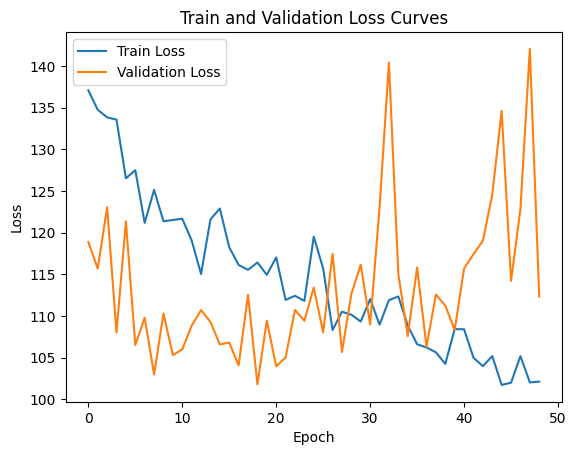


106.02769470214844 104.71508026123047 best keys
dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input'])
train_input_loop_3
106.48977661132812 111.76688385009766 109.9505615234375 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input', 'home_PER_input', 'away_PER_input'])
Best loss = 101.92486572265625, Best validation_loss = 101.39293670654297
Best accuracy = 0.6919602751731873, Best validation_accuracy = 0.6666666865348816
Best mse = 100.62165069580078, final validation_mse = 100.75172424316406


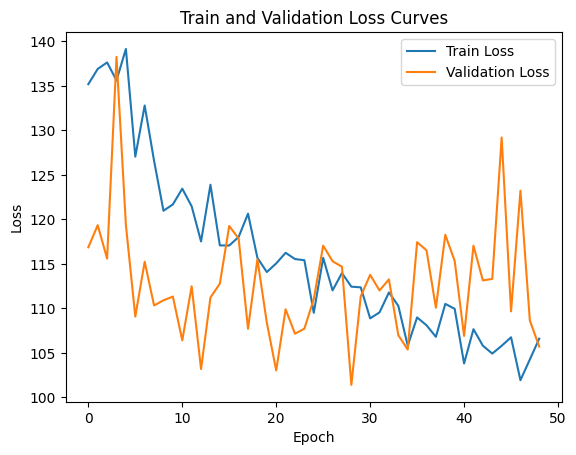



 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input', 'home_TS%_input', 'away_TS%_input'])
Best loss = 89.07073974609375, Best validation_loss = 99.57630920410156
Best accuracy = 0.7344173192977905, Best validation_accuracy = 0.6504064798355103
Best mse = 89.36365509033203, final validation_mse = 98.92938995361328


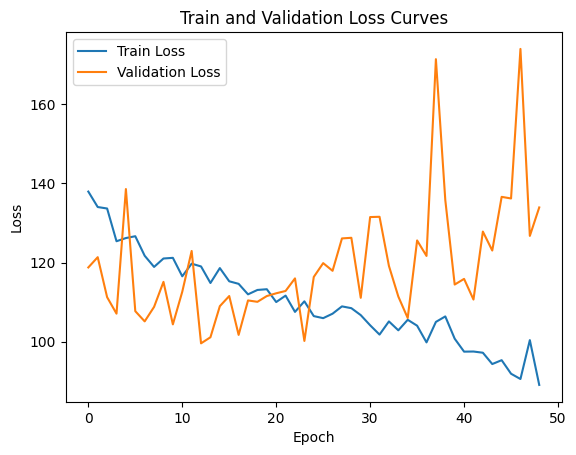


105.04119873046875 107.7132797241211 106.53079986572266 107.67669677734375 104.63265228271484 107.706298828125 108.61717224121094 106.72362518310547 107.30467987060547 105.0557632446289 105.49079895019531 104.57180786132812 106.9953384399414 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input', 'home_OBPM_input', 'away_OBPM_input'])
Best loss = 97.95003509521484, Best validation_loss = 98.74746704101562
Best accuracy = 0.6973803043365479, Best validation_accuracy = 0.6585366129875183
Best mse = 100.07136535644531, final validation_mse = 98.10163116455078


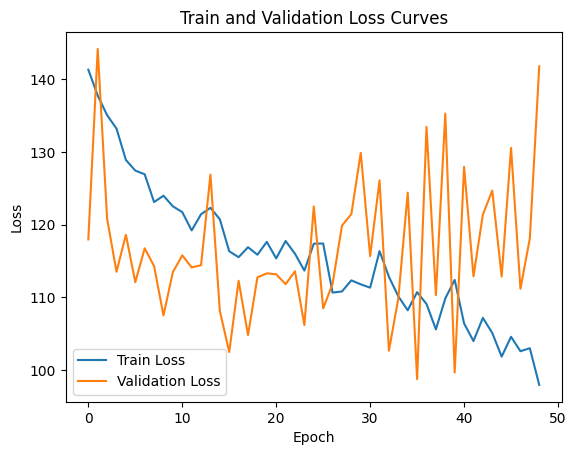


105.54033660888672 103.67473602294922 103.44575500488281 best keys
dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input', 'home_OBPM_input', 'away_OBPM_input'])
train_input_loop_4

 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input', 'home_OBPM_input', 'away_OBPM_input', 'home_Age_input', 'away_Age_input'])
Best loss = 100.65229034423828, Best validation_loss = 97.27241516113281
Best accuracy = 0.7055103778839111, Best validation_accuracy = 0.6585366129875183
Best mse = 100.5910415649414, final validation_mse = 96.6472396850586


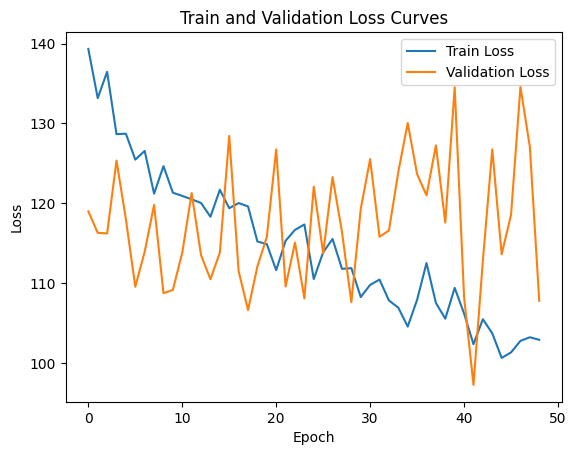


109.9367904663086 110.79286193847656 102.7393798828125 105.86980438232422 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input', 'home_OBPM_input', 'away_OBPM_input', 'home_3PAr_input', 'away_3PAr_input'])
Best loss = 89.8179931640625, Best validation_loss = 97.13384246826172
Best accuracy = 0.7235772609710693, Best validation_accuracy = 0.642276406288147
Best mse = 88.95252227783203, final validation_mse = 96.49667358398438


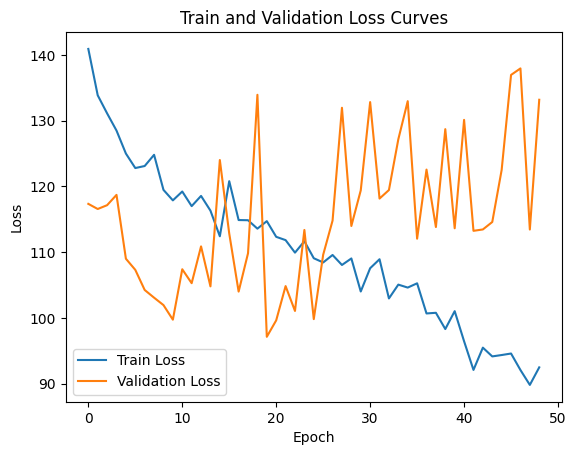


101.43502807617188 102.97814178466797 105.31584167480469 97.62821197509766 103.82392883300781 100.62109375 103.37396240234375 107.50732421875 105.61870574951172 103.39382934570312 104.05651092529297 103.20918273925781 101.56553649902344 105.85309600830078 103.32870483398438 best keys
dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_DWS_input', 'away_DWS_input', 'home_BPM_input', 'away_BPM_input', 'home_OBPM_input', 'away_OBPM_input', 'home_3PAr_input', 'away_3PAr_input'])
train_input_loop_5
99.24617004394531 111.94340515136719 108.8940200805664 105.18792724609375 106.8738784790039 103.36628723144531 105.2165298461914 104.478515625 102.90978240966797 105.52543640136719 106.96574401855469 106.4093017578125 108.37371826171875 105.49787902832031 105.10269165039062 107.11002349853516 101.89329528808594 100.89354705810547 105.13203430175781 103.15895080566406 best model params above


<Figure size 640x480 with 0 Axes>

In [13]:
x_train, y_train= pre_process_binary('2016-17', top_n=8, subset = True)
# x_test, y_test= pre_process_binary('2017-18',top_n=8, subset = True)

train_core= {}
for stat in core_stats:
    train_core[stat] = x_train[stat]

player_subset =  train_input_loop(train_core, home_keys, away_keys, 1000, 0)

In [14]:
def select_features(train_data):
    train_subset = {}
    features = player_subset
    for key in features:
        train_subset[key]=train_data[key]
    return train_subset

## Results

In this experiment we ran a genetic algorithm to determine which of the advanced player stats should be used in the model. We took this approach because the amount of player stats we had access to was quite large, however, none seemed to directly impact the spread, so we chose to include as many as possible. By iterating over all of the various combinations, we were able to reduce the overall amount of legwork required in our investigation.

Each of the player statistics used in our model correspond to the 8 highest values of that statistic from the players on that team. This was done as we thought it would best approximate starting roster of each team as well as any substitutions that may occur throughout a game. Overall our dataset contained 23 advance player stats and our feature selection algorithm reduced the player stats dataset to 4 critical player statistics for the home and away teams- Defensive Win Shares (DWS input), Box Plus Minus (BPM), Offensive Box Plus Minus (OBPM), and 3 point attempt rate (3PAr). The first iteration identified Defensive Win Shares as the player statistic most influential to the validation loss of the model. Although this didn’t affect the validation loss very much the validation accuracy increased from 52.8% to 65% and the mean squared error decreased by 1 point. Although subsequent additions of player stats didn’t have as dramatic effect on the model results; Box Plus Minus (BPM), Offensive Box Plus Minus (OBPM), and 3 point attempt rate (3PAr). Were identified as features decreasing the loss  of the model. The incorporation of these feature brought the validation accuracy of the model up to 66.6%, the validation loss down to 101.39, and the validation mean squared error down to 100.75. 

Despite the improvement of the models performance, the addition of each player statistic resulted in increased evidence of overfitting when looking at the training and validation loss curves. This led to a notable enhancement in both accuracy and loss metrics during validation, suggesting that player-level statistics play a crucial role in predicting game outcomes. Overall, these findings underscore the importance of feature selection and highlight the significance of incorporating player-level insights in predictive modeling for NBA games.

## Experiment 5 -- Would a Principal Component of the Advance Player Stats Yield Better Results than the Mutation-Free Genetic Algorithm?

A different approach to a similar problem, we ran principal component analysis (PCA) to see if a dimensionality reduction would help improve results and reduce overfitting. 

In [15]:
x_train, y_train, pca, imp = pre_process_pca_binary('2016-17', top_n=8, subset = True, pca= None, imp= None)
# x_test, y_test, pca, imp= pre_process_pca_binary('2017-18', top_n=8, subset = False, pca= pca, imp= imp)

In [16]:
l1 = 0
for key in x_train.keys():
    l1+=x_train[key].shape[1]
model = build_lasso_model(x_train, y_train, model_name="pca_stats", layers=[l1, l1, l1, l1], activation_function="gelu", show_summary=False, l1_val=best_val)
history = model.fit(x=x_train, y=y_train, epochs=50, batch_size=150, validation_split = 0.1, verbose = 0)
print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
print()

Best loss = 93.443603515625, Best validation_loss = 111.10198974609375
Best accuracy = 0.6901535391807556, Best validation_accuracy = 0.6260162591934204
Best mse = 93.1492691040039, final validation_mse = 110.01058197021484



## Results

Looking at PCA advanced stats performs slightly worse than the mutation-free genetic algorithm with the same amount hyper parameters, but since the training validation gap is smaller, the model is overfitting less and has potential to do better with more training. Applying PCA advanced statistics doesn't show potential for improvement after viewing the loss curves, though it overfits the data less.

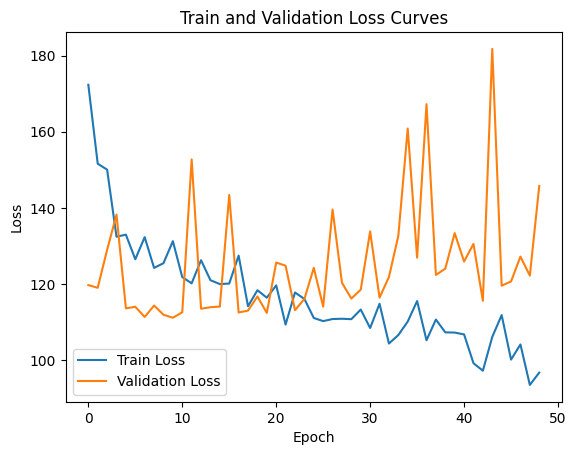

In [17]:
plt.plot(history.history['loss'][1:], label='Train Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.title('Train and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Detailed View of the Results from Current Model Training 

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
accuracy:  0.683739837398374


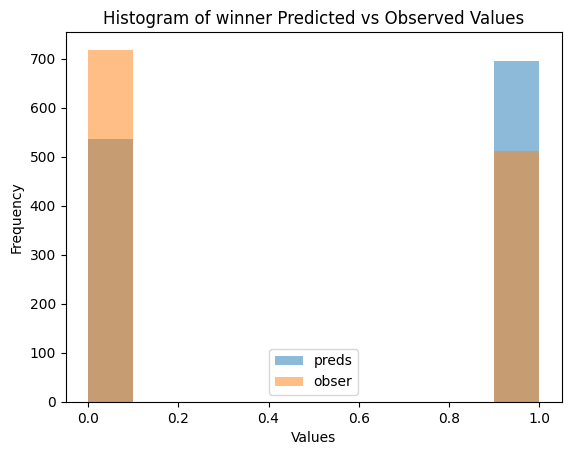

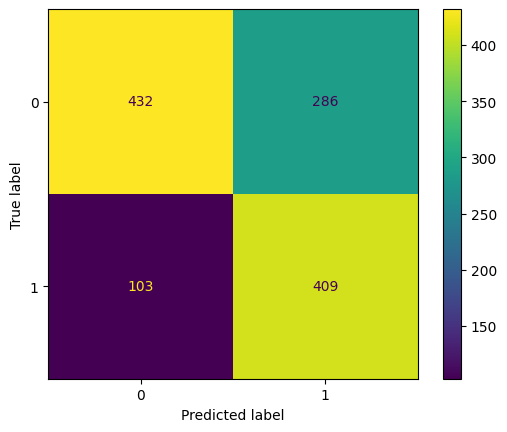

accuracy:  30.339024390243903


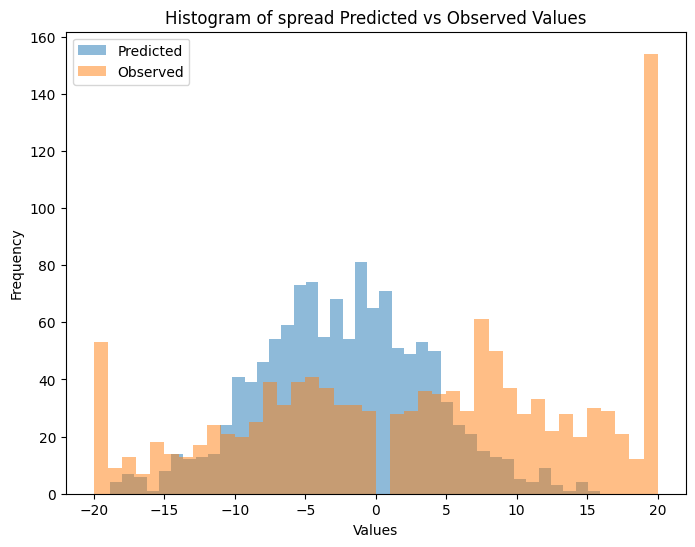

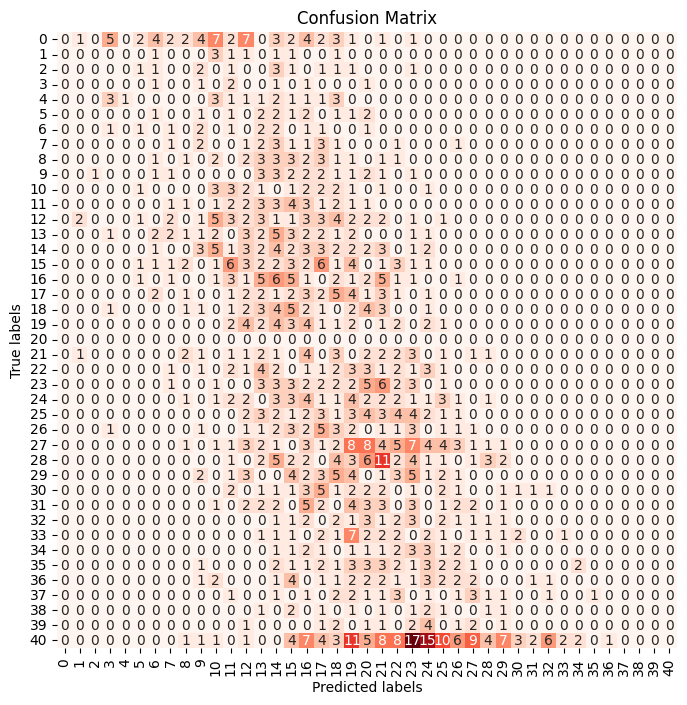

In [18]:
#look at spread predictions 
predictions = model.predict(x_train)
spread = predictions[0]
putcome = predictions[1]
#outcome
predictions = np.argmax(putcome, axis = 1)
print("accuracy: ", calculate_accuracy(np.argmax(y_train['outcome'],  axis =1), predictions))
plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
observed = np.argmax(y_train['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.savefig('fs_outcome_hist.png')
plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.savefig('fs_outcome_cm.png')
plt.show()
 
#spread 
print("accuracy: ", calculate_accuracy(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int)))
plt.figure(figsize=(8, 6))
plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_train['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.savefig('fs_spread_hist.png')
plt.show()
 
cmap = sns.color_palette("Reds", as_cmap=True)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_train['spread'], np.round(spread).astype(int)), cmap=cmap, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('fs_spread_cm.png')
plt.show()

In [19]:
x_train, y_train= pre_process_binary('2016-17', top_n=8, subset = True)
# x_test, y_test= pre_process_binary('2017-18',top_n=8, subset = True)

In [20]:
x_train_select= select_features(x_train)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
accuracy:  0.7024390243902439


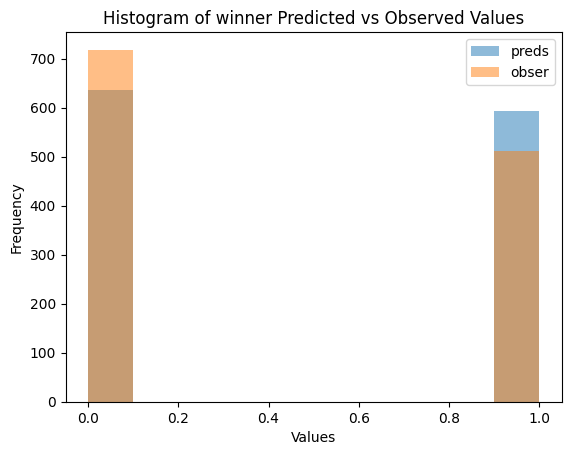

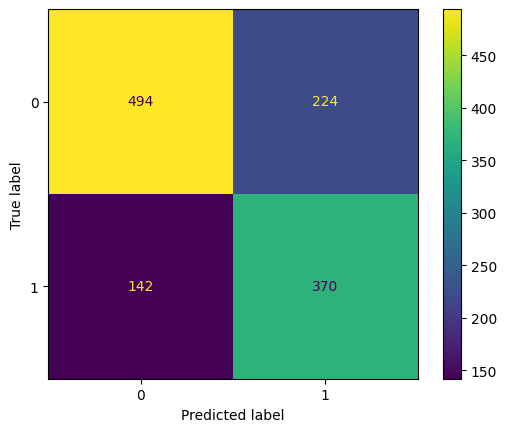

accuracy:  31.776422764227643


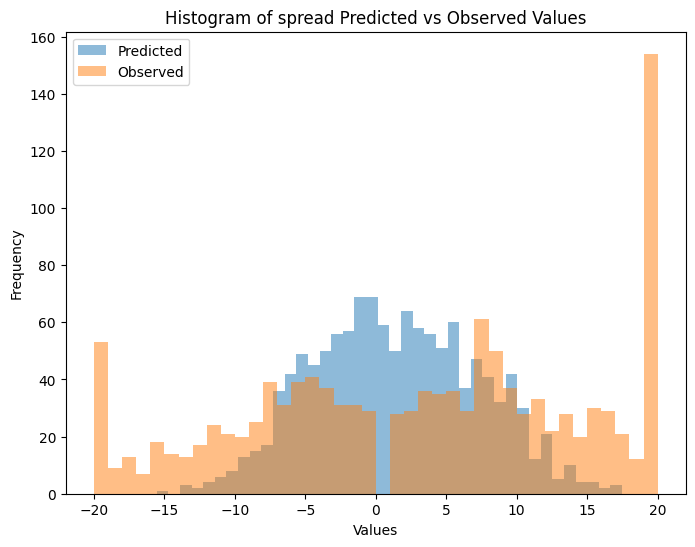

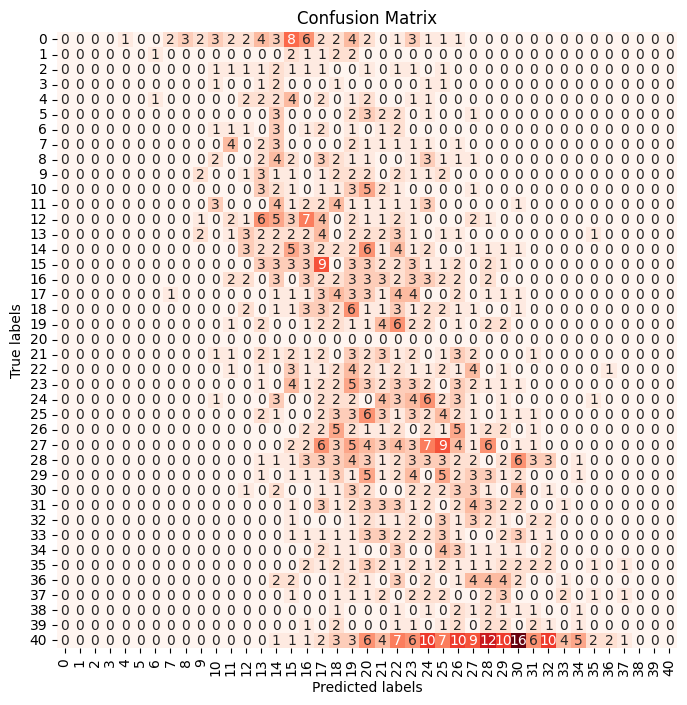

In [21]:
model = tf.keras.models.load_model('efs_model.keras')
#look at spread predictions 
predictions = model.predict(x_train_select)
spread = predictions[0]
putcome = predictions[1]
#outcome
predictions = np.argmax(putcome, axis = 1)
print("accuracy: ", calculate_accuracy(np.argmax(y_train['outcome'],  axis =1), predictions))
plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
observed = np.argmax(y_train['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.savefig('fs_outcome_hist.png')
plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.savefig('fs_outcome_cm.png')
plt.show()
 
#spread 
print("accuracy: ", calculate_accuracy(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int)))
plt.figure(figsize=(8, 6))
plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_train['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.savefig('fs_spread_hist.png')
plt.show()
 
cmap = sns.color_palette("Reds", as_cmap=True)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_train['spread'], np.round(spread).astype(int)), cmap=cmap, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('fs_spread_cm.png')
plt.show()

## Results

The current model is very good at predicting the outcome of games at 0.69, but not as good at predicting the spreads at an accuracy score of 0.31.

# Fine Tuning Model Parameters

## Experiment 6 -- How do Dropout Layers and Rates Ipact Model Performance

To help reduce model over-fitting to data, we used an iterative approach to drop out layer placement and neuron dropout rate. Dropout layers help create a more robust and generalizable model, which would help to perform across seasons better.

Dropout Rate:  0.01 , layers:  [0, 0, 0, 0, 0]
Best loss = 79.71204376220703, Best validation_loss = 100.27275085449219
Best accuracy = 0.760614275932312, Best validation_accuracy = 0.6585366129875183
Best mse = 79.72639465332031, final validation_mse = 99.5697021484375

Dropout Rate:  0.01 , layers:  [0, 0, 0, 0, 1] loss:  103.29 Dropout Rate:  0.01 , layers:  [0, 0, 0, 1, 0] loss:  101.98 Dropout Rate:  0.01 , layers:  [0, 0, 0, 1, 1] loss:  105.63 Dropout Rate:  0.01 , layers:  [0, 0, 1, 0, 0] loss:  105.59 Dropout Rate:  0.01 , layers:  [0, 0, 1, 0, 1] loss:  102.37 Dropout Rate:  0.01 , layers:  [0, 0, 1, 1, 0] loss:  102.77 Dropout Rate:  0.01 , layers:  [0, 0, 1, 1, 1]
Best loss = 99.40616607666016, Best validation_loss = 98.20255279541016
Best accuracy = 0.7046070694923401, Best validation_accuracy = 0.6341463327407837
Best mse = 98.46558380126953, final validation_mse = 97.52192687988281

Dropout Rate:  0.01 , layers:  [0, 1, 0, 0, 0] loss:  102.76 Dropout Rate:  0.01 , layers

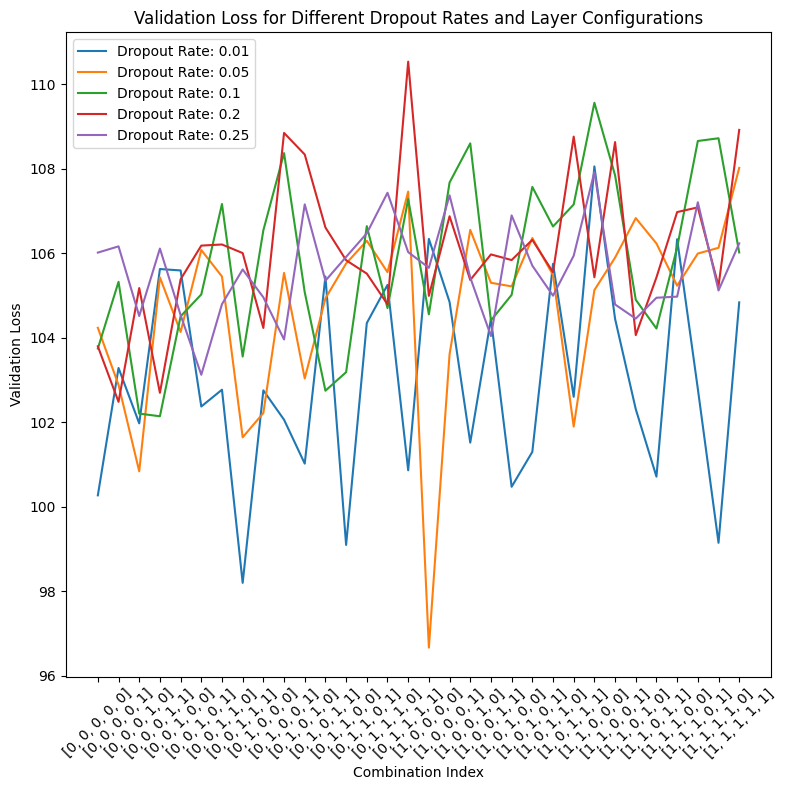

In [22]:
dropout_tup = None
l1 = 0
for key in x_train_select.keys():
    l1+=x_train_select[key].shape[1]
array = [1, 1, 1, 1, 1]
combinations = generate_combinations(array)
drop_rate = [0.01, 0.05, 0.1, 0.2, 0.25]
best_loss = 1000
params = (0,[])
best_params = (0,[])
do_loss = []
do_val_loss = []
plt.figure(figsize=(8, 8))
for val in drop_rate:
    loss_values = []
    for combination in combinations:  
        model = build_model_do(x_train_select, y_train, val, combination, model_name="core_stats", layers=[l1, l1, l1, l1], activation_function="gelu", show_summary=False)
        history = model.fit(x=x_train_select, y=y_train, epochs=50, batch_size=150, validation_split = 0.1, verbose = 0)
        do_loss.append(history.history['loss'])
        do_val_loss.append(history.history['val_loss'])
        params = (val, combination)
        cur_loss = min(history.history['val_loss'])
        loss_values.append(cur_loss)
        if cur_loss<best_loss:
            print("Dropout Rate: ", val, ", layers: ", combination)
            best_loss = cur_loss 
            best_params = params  
            dropout_tup = (val, combination)
            print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
            print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
            print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
            print()
        else:
            print("Dropout Rate: ", val, ", layers: ", combination, "loss: ",  round(cur_loss, 2), end = " ")
    plt.plot(range(len(combinations)), loss_values, label=f"Dropout Rate: {val}") 
print("\n Best Params: ", best_params)
plt.title('Validation Loss for Different Dropout Rates and Layer Configurations')
plt.xlabel('Combination Index')
plt.ylabel('Validation Loss')
plt.xticks(range(len(combinations)), [str(combination) for combination in combinations], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('droupout_testing.png')
plt.show()

### Results

Our best results were found at a dropout rate of 0.05 with a lower validation loss across earlier placement of the dropout layer [1, 0, 0, 0, 0]. This configuration demonstrated the lowest loss and highest accuracy, suggesting it strikes an effective balance between learning and generalization. Other dropout rates, especially higher ones like 0.2 and 0.25, tend to result in higher validation losses, implying a potential over-regularization that hinders the network’s performance.

Interestingly, there does not seem to be patterns of banding or regularization for the dropout, reinforcing our iterative approach to model exploration.

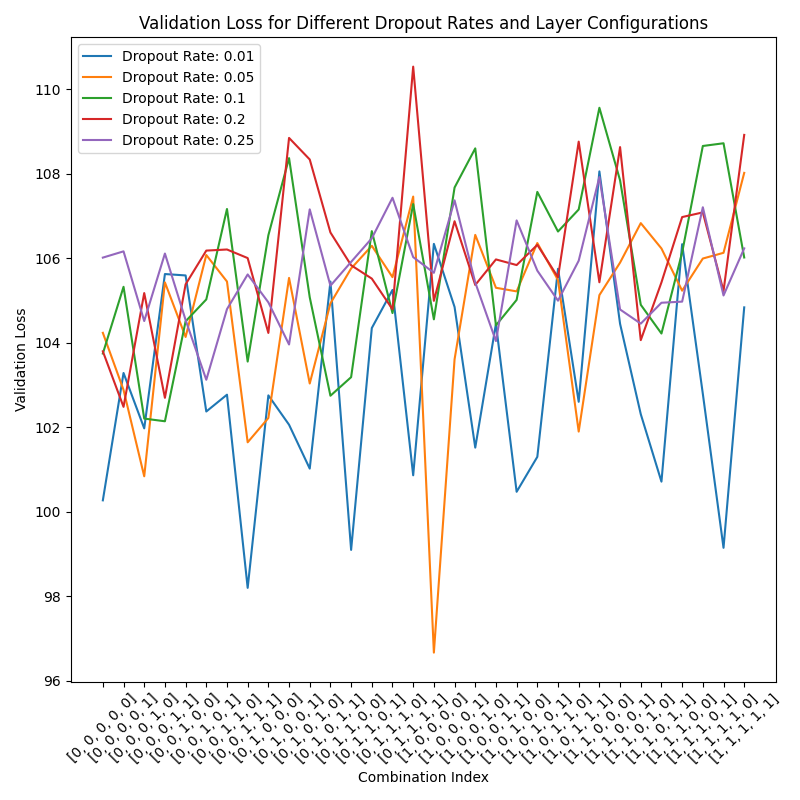

In [47]:
Image("droupout_testing.png")

## Model Experiment 7: Activation function Experiment
We had established that **gelu** was the better activation function from earlier tests. However, we did not know whether this remained true since we had added numerous statistics to improve the performance of predicting the outcome and spread. 

To test this, we cycled through different activation functions, to test which was the better peformer. The activation functions being tested are the following: **relu, leaky_relu, swish, mish, tanh, gelu, selu**. 

Finally, a bar chart of the activation function with the least validation loss was plotted.
*(contributed by: Mervin McDougall)*

In [72]:
# Assuming combinations and x_train_select are defined somewhere

array = [0, 1, 1, 1, 1]
combinations = [[0, 0, 0, 0, 0]]
l1 = 0
for key in x_train_select.keys():
    l1 += x_train_select[key].shape[1]

activation_function = ['tanh', 'relu', 'leaky_relu', 'swish', 'mish', 'gelu', 'selu']
best_loss = 1000
params = (0, [])
best_params = (0, [])
plt.figure(figsize=(8, 8))

# Initialize loss_values as a dictionary to store loss values for each activation function
loss_values = {af: [] for af in activation_function}

for af in activation_function:
    for combination in combinations:
        model = build_model_do(x_train_select, y_train, dropout_tup[0], dropout_tup[1], model_name="core_stats", layers=[l1, l1, l1, l1], activation_function=af, show_summary=False)
        history = model.fit(x=x_train_select, y=y_train, epochs=50, batch_size=150, validation_split=0.1, verbose=0)
        params = af
        cur_loss = min(history.history['val_loss'])
        loss_values[af].append(cur_loss)
        if cur_loss < best_loss:
            print("Activation Function: ", af, ", layers: ", combination)
            best_loss = cur_loss 
            best_params = params  
            print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
            print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
            print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
            print()
        else:
            print("Activation Function: ", af, ", layers: ", combination, "loss: ", round(cur_loss, 2), end="\n")

Activation Function:  tanh , layers:  [0, 0, 0, 0, 0]
Best loss = 83.91578674316406, Best validation_loss = 103.20541381835938
Best accuracy = 0.7461608052253723, Best validation_accuracy = 0.6341463327407837
Best mse = 84.65616607666016, final validation_mse = 102.50360870361328

Activation Function:  relu , layers:  [0, 0, 0, 0, 0] loss:  107.76
Activation Function:  leaky_relu , layers:  [0, 0, 0, 0, 0] loss:  110.99
Activation Function:  swish , layers:  [0, 0, 0, 0, 0] loss:  104.6
Activation Function:  mish , layers:  [0, 0, 0, 0, 0] loss:  107.37
Activation Function:  gelu , layers:  [0, 0, 0, 0, 0] loss:  108.3
Activation Function:  selu , layers:  [0, 0, 0, 0, 0] loss:  107.21


<Figure size 800x800 with 0 Axes>


 Best Params:  tanh


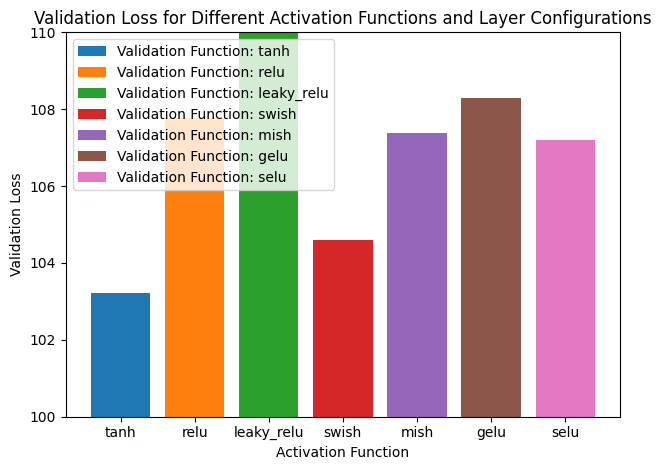

In [73]:
# Plotting bar chart for each activation function's loss
for af in activation_function:
    plt.bar(af, min(loss_values[af]), label=f"Validation Function: {af}")
print("\n Best Params: ", best_params)
plt.title('Validation Loss for Different Activation Functions and Layer Configurations')
plt.xlabel('Activation Function')
plt.ylabel('Validation Loss')
plt.ylim(100, 110)
plt.legend()
plt.tight_layout()
plt.savefig('activation_function_testing.png')
plt.show()

## Results
Although it was hoped that the test would provide more insight into the effects of the activation on the improved data set, we did not have a clear winner. Instead, each run revealed a new activation function with the lowest validation loss. We, however, settled on **tanh** as a better performer from a previous test which included swapping out the combination of layers. This was used for future experiments.

A better experiment would probably involve taking an average of the validation loss for each of the activation functions after performing a fixed number of trials. This will probably 

## Experiment 8 -- How will the Addition of Batch Normalization Layers affect the Models Performance?

To create a more generalized model, we attempted batch normalization layers to help improve performance. When you look at the overall range for the spread of games, there is an incredibly wide range -- from negative 20 to positive 20. We felt that batch normalization could help the model learn more rapidly.

In [86]:
x_train, y_train= pre_process_binary('2016-17', top_n=8, subset = True)
x_train_select= select_features(x_train)


Best parameters: [0, 0, 0, 0, 0]
Best loss = 88.78031921386719, Best validation_loss = 99.1025390625
Best accuracy = 0.7280939221382141, Best validation_accuracy = 0.642276406288147
Best mse = 88.32029724121094, final validation_mse = 98.39657592773438

109.77449798583984 119.68885040283203 122.59243774414062 107.02954864501953 112.54096221923828 116.98084259033203 121.95481872558594 145.4075927734375 125.1279296875 115.37168884277344 114.55388641357422 120.22476959228516 112.78787231445312 116.49827575683594 121.90401458740234 110.82701873779297 118.19377136230469 117.43251037597656 110.25383758544922 120.19391632080078 127.49329376220703 116.13333129882812 119.01448059082031 113.45225524902344 109.63040161132812 114.31839752197266 119.97440338134766 124.97865295410156 119.989501953125 118.3838119506836 120.91500854492188 best params:  [0, 0, 0, 0, 0]


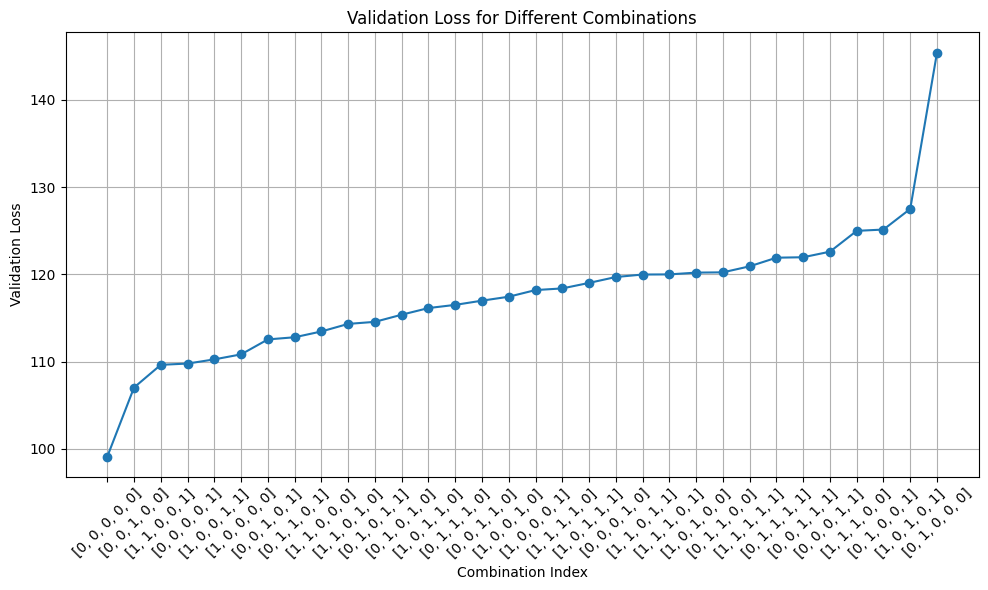

In [87]:
# Initialize variables
loss_values = []
best_loss = 1000

l1 = 0
for key in x_train_select.keys():
    l1+=x_train_select[key].shape[1]

plt.figure(figsize=(10, 6))
combinations = generate_combinations(array)
for combination in combinations:  
    # Build the model
    model = build_model_bn(x_train_select, y_train, dropout_tup[0], dropout_tup[1], combination, "core_stats", [l1, l1, l1, l1], "swish", False)
    history = model.fit(x=x_train_select, y=y_train, epochs=50, batch_size=150, validation_split=0.1, verbose=0)
    
    # Update loss values
    cur_loss = min(history.history['val_loss'])
    loss_values.append(cur_loss)
    
    # Update best parameters
    if cur_loss < best_loss:
        best_loss = cur_loss 
        best_params = combination
        print("\nBest parameters:", best_params)
        print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
        print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
        print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
        print()
    else:
        print(cur_loss, end = " ")
print("best params: ", best_params)
# Plot the results
sorted_combinations = [x for _, x in sorted(zip(loss_values, combinations))]
sorted_loss_values = sorted(loss_values)

# Plot the results
plt.plot(range(len(sorted_combinations)), sorted_loss_values, marker='o', linestyle='-')
plt.title('Validation Loss for Different Combinations')
plt.xlabel('Combination Index')
plt.ylabel('Validation Loss')
plt.xticks(range(len(sorted_combinations)), [str(combination) for combination in sorted_combinations], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('batch_normalization_testing.png')
plt.show()

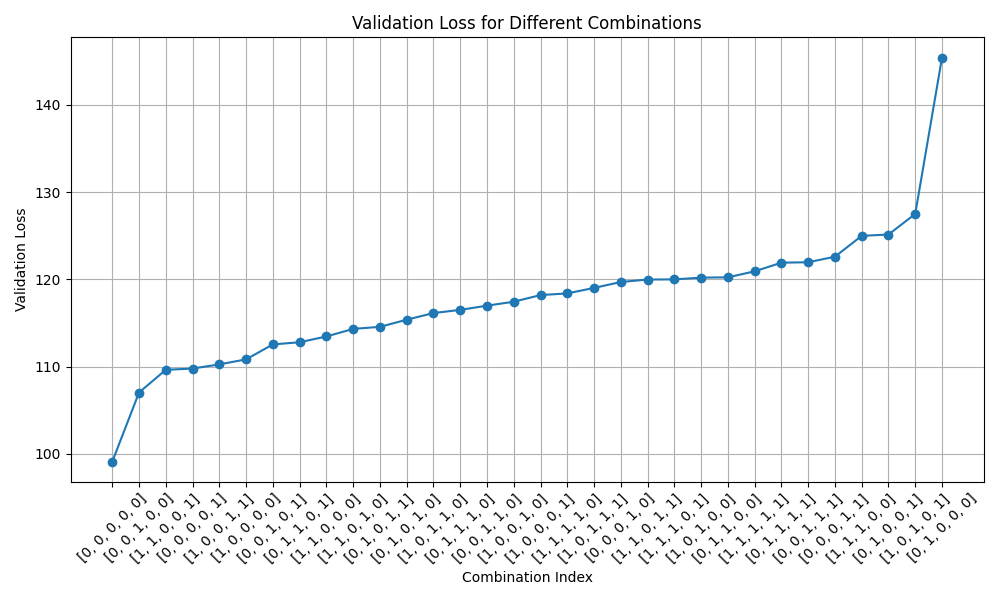

In [88]:
Image('batch_normalization_testing.png')

## Results

We discovered that batch normalization did not improve model results. Although the layers were selected in order, the resulting graph displays them in order of increasing validation loss. The same layers did not consistently generate a loss or gain over numerous tests. Therefore we concluded, that the batch normalization did not generate a consistent result when attempting to predict on training data. This lack of consistency led us to drop batch normalization from our model.


## Detailed View of Model Performance with the Addition of Dropout Layers

In [89]:
# current best model 
l1 = 0
for key in x_train_select.keys():
    l1+=x_train_select[key].shape[1]
model = build_model_do(x_train_select, y_train, dropout_tup[0], dropout_tup[1] , model_name="core_stats", layers=[l1, l1, l1, l1], activation_function="tanh", show_summary=False)
history = model.fit(x=x_train_select, y=y_train, epochs=50, batch_size=150, validation_split = 0.1, verbose = 0)
model.save("cb_model.keras")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
accuracy:  0.7040650406504065


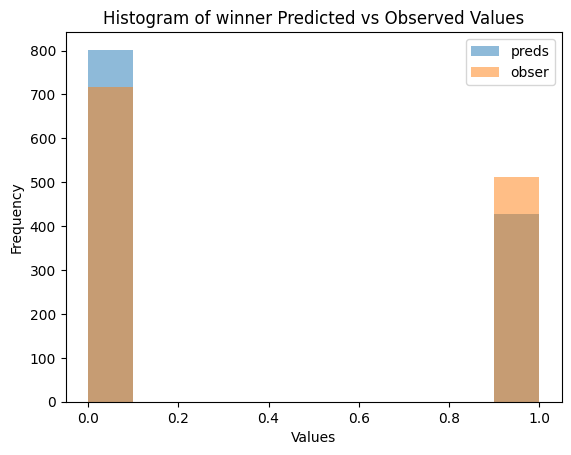

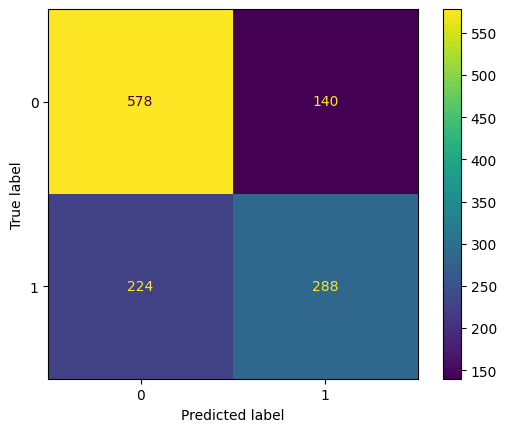

accuracy:  30.51219512195122


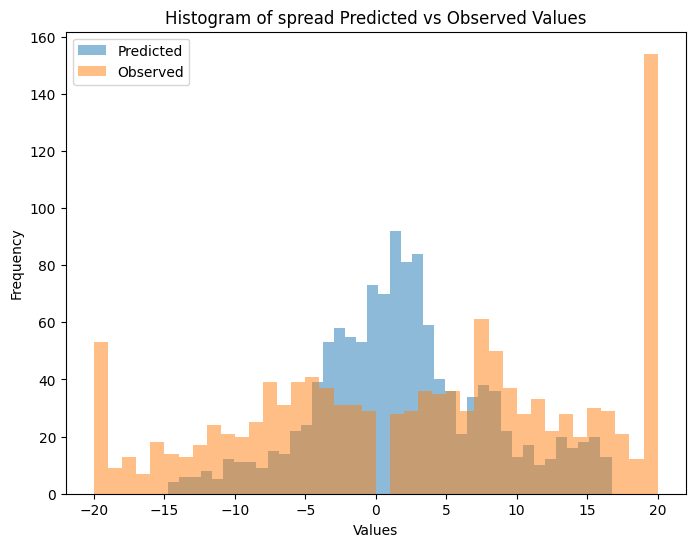

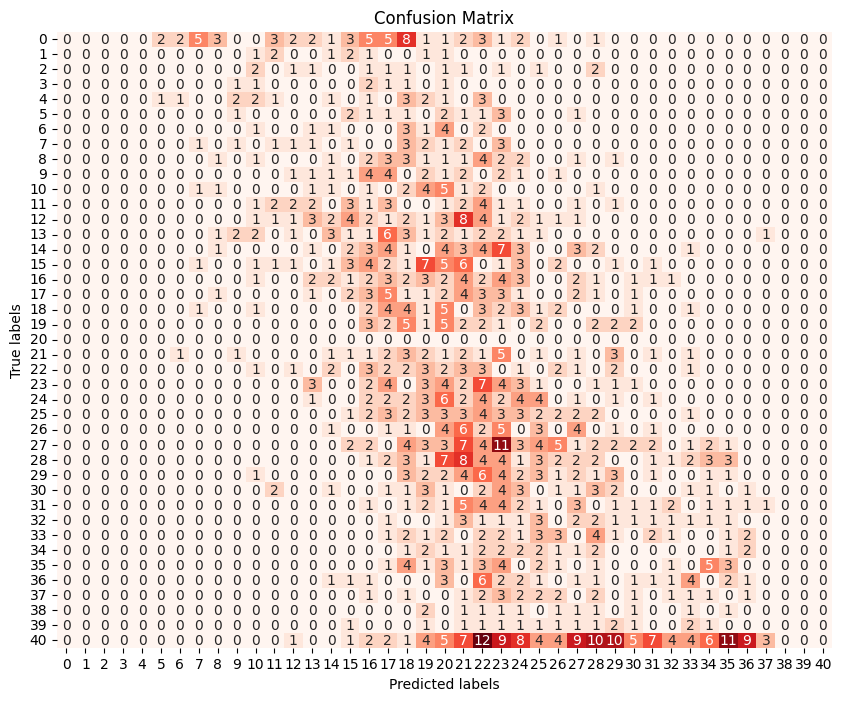

In [90]:
#look at spread predictions 
model = tf.keras.models.load_model("cb_model.keras")
predictions = model.predict(x_train_select)
spread = predictions[0]
putcome = predictions[1]
#outcome
predictions = np.argmax(putcome, axis = 1)
print("accuracy: ", calculate_accuracy(np.argmax(y_train['outcome'],  axis =1), predictions))
plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
observed = np.argmax(y_train['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.savefig('cb_outcome_hist.png')
plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.savefig('cb_outcome_cm.png')
plt.show()
 
#spread 
print("accuracy: ", calculate_accuracy(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int)))
plt.figure(figsize=(8, 6))
plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_train['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.savefig('cb_spread_hist.png')
plt.show()
 
cmap = sns.color_palette("Reds", as_cmap=True)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train['spread'], np.round(spread).astype(int)), cmap=cmap, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('cb_spread_cm.png')
plt.show()

## Hyper Parameter Grid Search

In [91]:
def model_hp_testing(x_dict, y_dict, name, spread_loss, outcome_loss, this_optimizer, activation_function, last_act, show_summary = False):
    model_name = name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    concat_input= []
    l1 = 0
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        if input == "home_avg_stats_input":
            # create l1 reg
            home_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation=activation_function,  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(home_avg_stats_input_d )
            l1+=x_dict[input].shape[1]
        elif input == "away_avg_stats_input":
            # create l1 reg
            away_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation=activation_function,  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(away_avg_stats_input_d)
            l1+=x_dict[input].shape[1]
 
        else:
            l1+=x_dict[input].shape[1]
            concat_input.append(input_dict[input])
    # dropout params 0.1 , layers:  [0, 1, 1, 1, 0]
    concatenated_inputs = tf.keras.layers.concatenate(concat_input)
    h1 = tf.keras.layers.Dense(l1, activation=activation_function)(concatenated_inputs)
    h2 = tf.keras.layers.Dense(l1, activation=activation_function)(h1)
    h2d = tf.keras.layers.Dropout(0.2)(h2)
    h3 = tf.keras.layers.Dense(l1, activation=activation_function)(h2d)
    h3d = tf.keras.layers.Dropout(0.2)(h3)
    h4 = tf.keras.layers.Dense(l1, activation=activation_function)(h3d)
    h4d = tf.keras.layers.Dropout(0.2)(h4)
    h5 = tf.keras.layers.Dense(l1, activation=activation_function)(h4d)
    concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5, input_dict['away_team_input']])
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation=last_act, name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':spread_loss , 'outcome':outcome_loss}, optimizer=this_optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), "accuracy"])
    
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

# Experiment 9 -- Spread Loss and Last Layer Activation Grid Search 

In order to further fine tune our model, we looked at a variety of different loss functions, including MSE, MAE, and Huber to find what fit our model best. In addition, we tried two different types of "last layer" functions in softplus and softmax.

In [92]:
spread_loss = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError(), 
               # tf.keras.losses.Poisson(reduction="sum_over_batch_size"), tf.keras.losses.Poisson(reduction="sum"),
               tf.keras.losses.Huber(delta=0.5),tf.keras.losses.Huber(delta=1.0), tf.keras.losses.Huber(delta=1.5),
               tf.keras.losses.Huber(delta=1.0, reduction = "sum")]

last_layer_list = [tf.keras.activations.softplus, tf.keras.activations.softmax]

# save 3 best models for comparison 
top_models = []
new_best = 1000
params = {}
best_hp_loss = 0
best_hp_val_loss = 0
losses = []
 
for spread_loss_funct in spread_loss:
    params[spread_loss_funct] = {}
    for last_layer_funct in last_layer_list:
      # Train and evaluate the model with the current set of hyperparameters
            model = model_hp_testing(x_train_select, y_train, "model_name", spread_loss_funct, "mean_squared_error", "Nadam", "tanh", last_layer_funct)
            print(spread_loss_funct, last_layer_funct, end = " ")
            history = model.fit(x_train_select, y_train, epochs=50, batch_size = 150, verbose=False,
            validation_split = 0.3)
            cur_val_loss = min(history.history['val_loss'])
            # Update best parameters
            losses.append((f"{spread_loss_funct}, {last_layer_funct}",  cur_val_loss))
            if cur_val_loss < new_best:
                print(cur_val_loss)
                new_best = cur_val_loss
                params[spread_loss_funct][last_layer_funct] = cur_val_loss
                print("\nBest parameters:", spread_loss_funct, last_layer_funct)
                print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
                print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
                top_models.append(model)
                if len(top_models)>3:
                    top_models = top_models[1:]
                print()
            else:
                print(cur_val_loss, end = " ")
for model in range(len(top_models)):
    top_models[model].save(f"no{len(top_models)-model}_model.keras")

<keras.src.losses.losses.MeanSquaredError object at 0x3230adbd0> <function softplus at 0x28be8efc0> 125.00423431396484

Best parameters: <keras.src.losses.losses.MeanSquaredError object at 0x3230adbd0> <function softplus at 0x28be8efc0>
Best loss = 77.73053741455078, Best validation_loss = 125.00423431396484
Best accuracy = 0.7665505409240723, Best validation_accuracy = 0.631436288356781

<keras.src.losses.losses.MeanSquaredError object at 0x3230adbd0> <function softmax at 0x28be8ede0> 122.27276611328125

Best parameters: <keras.src.losses.losses.MeanSquaredError object at 0x3230adbd0> <function softmax at 0x28be8ede0>
Best loss = 76.83060455322266, Best validation_loss = 122.27276611328125
Best accuracy = 0.7514517903327942, Best validation_accuracy = 0.6368563771247864

<keras.src.losses.losses.MeanAbsoluteError object at 0x32266c310> <function softplus at 0x28be8efc0> 9.527670860290527

Best parameters: <keras.src.losses.losses.MeanAbsoluteError object at 0x32266c310> <function soft

/var/folders/yr/ck3hvtw16ks5djc79x7fgf6r0000gn/T/ipykernel_27077/1566369859.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


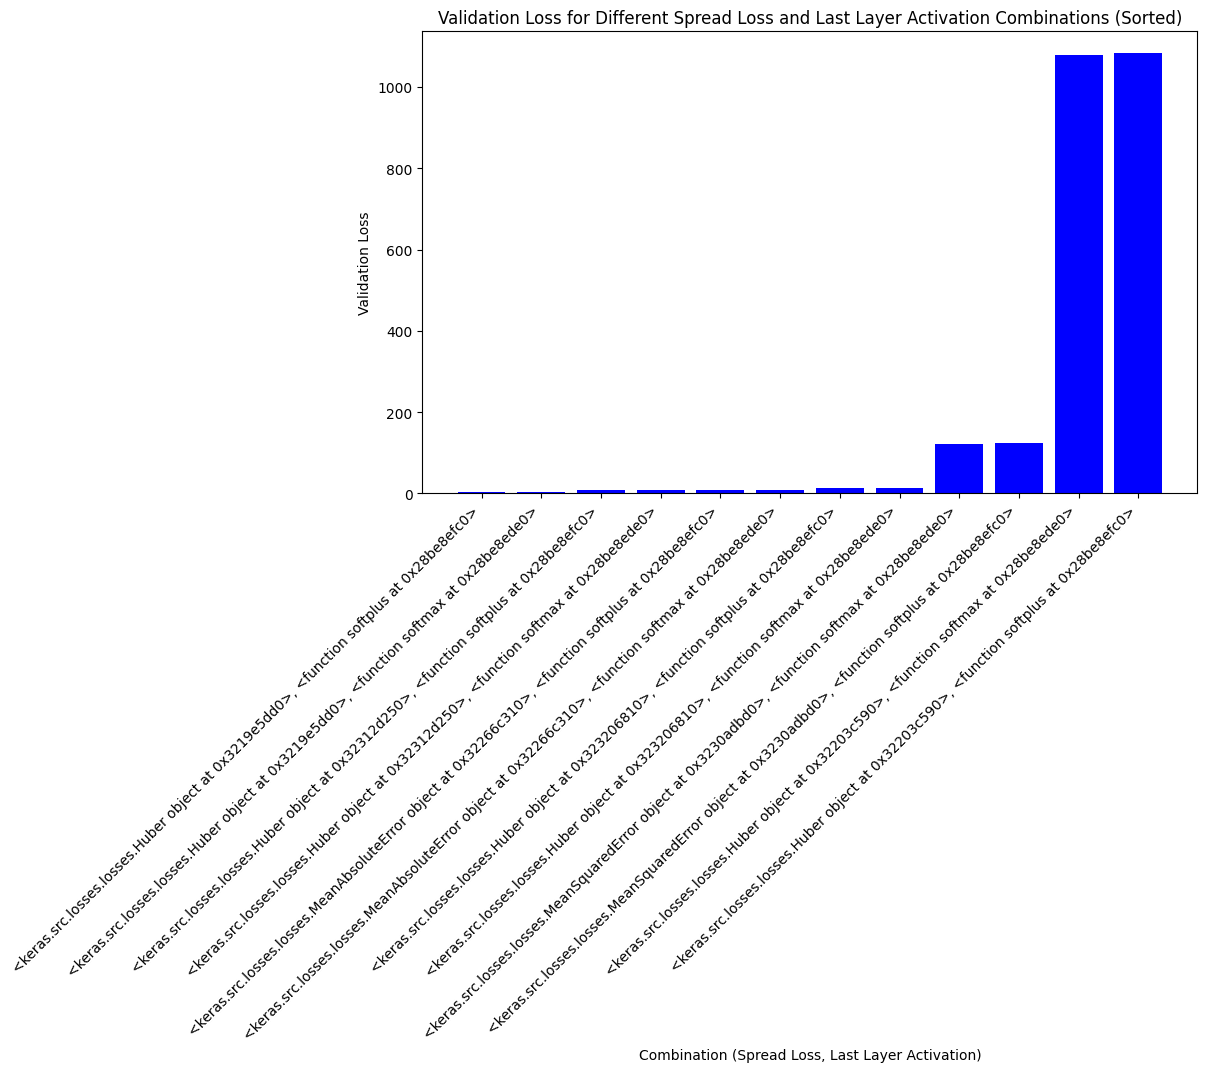

In [93]:
# Assuming losses is a list of tuples where each tuple contains a combination label and its validation loss
# Extract combination labels and validation losses
combinations = [loss[0] for loss in losses]
validation_losses = [loss[1] for loss in losses]

# Sort the combinations and validation losses based on validation loss (from best to worst)
sorted_losses = sorted(zip(combinations, validation_losses), key=lambda x: x[1])

# Extract sorted combinations and validation losses
sorted_combinations = [combination for combination, _ in sorted_losses]
sorted_validation_losses = [loss for _, loss in sorted_losses]

# Plot the validation losses for each combination
plt.figure(figsize=(10, 6))
plt.bar(sorted_combinations, sorted_validation_losses, color='blue')
plt.xlabel('Combination (Spread Loss, Last Layer Activation)')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Spread Loss and Last Layer Activation Combinations (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

no1_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
accuracy:  0.7073170731707317


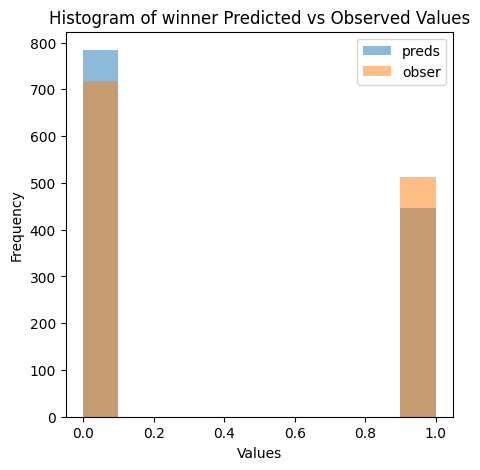

<Figure size 500x500 with 0 Axes>

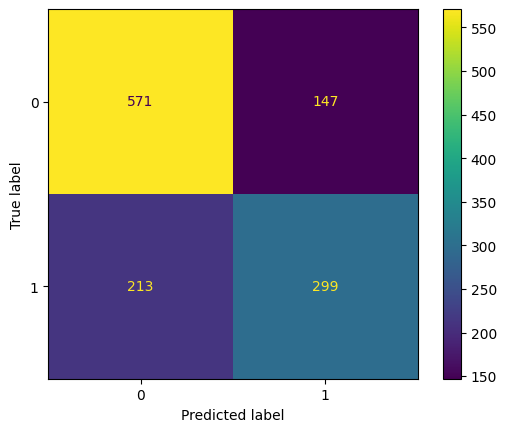

accuracy:  29.496747967479674


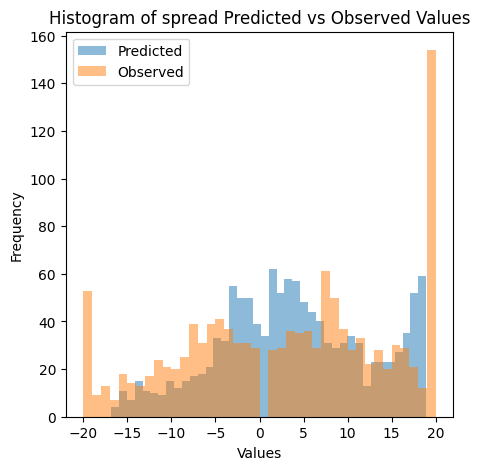

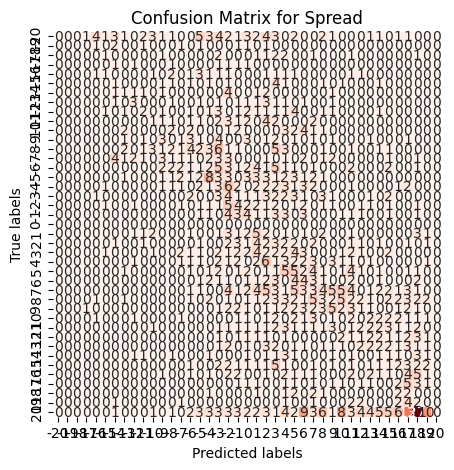

no2_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
accuracy:  0.7227642276422764


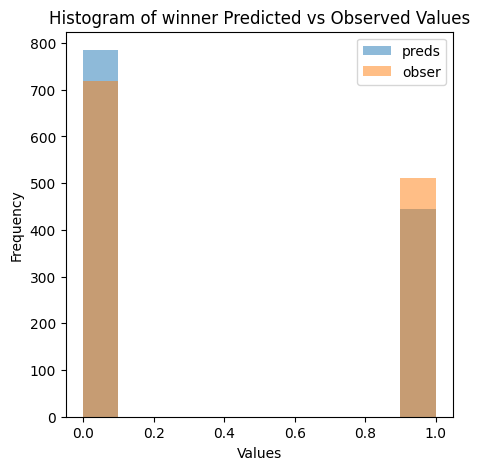

<Figure size 500x500 with 0 Axes>

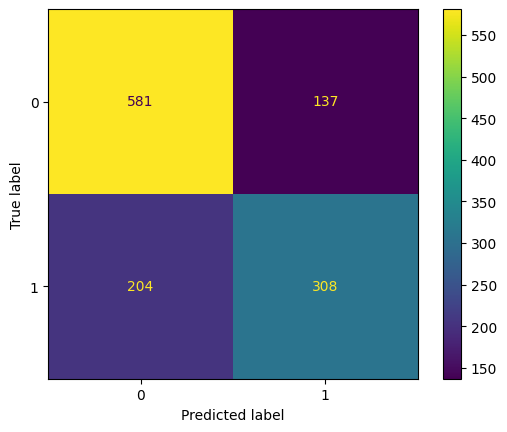

accuracy:  27.93089430894309


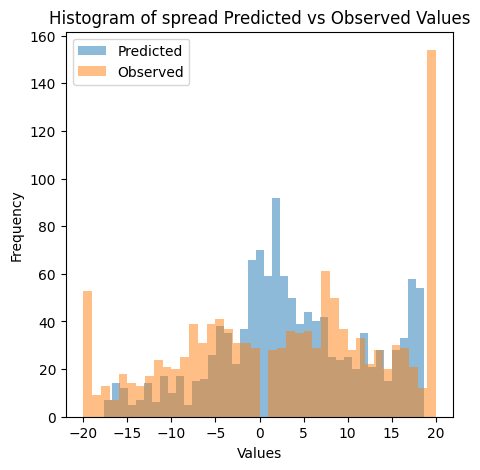

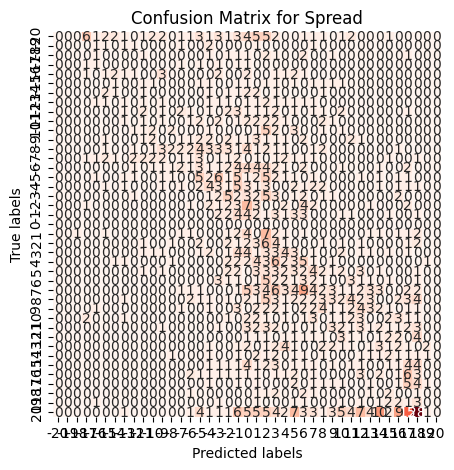

no3_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
accuracy:  0.71869918699187


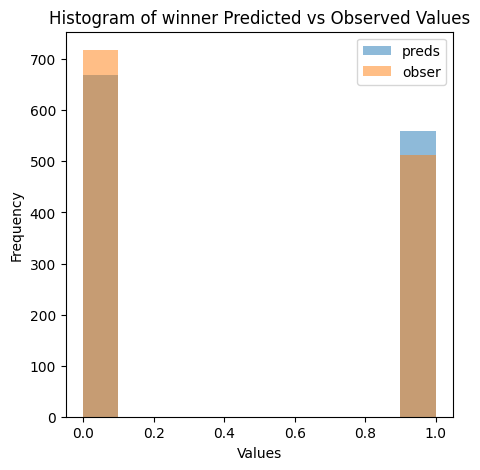

<Figure size 500x500 with 0 Axes>

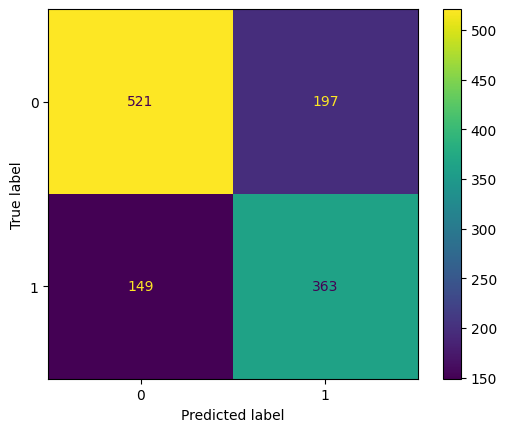

accuracy:  29.5869918699187


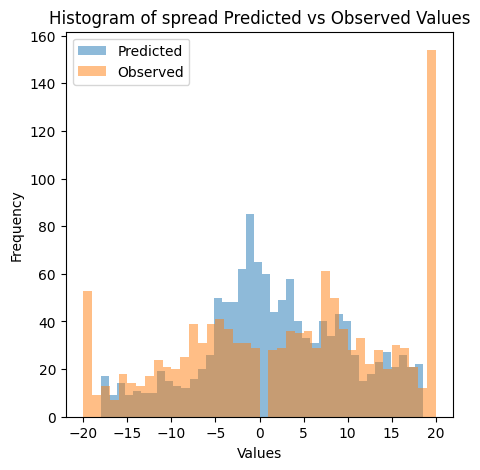

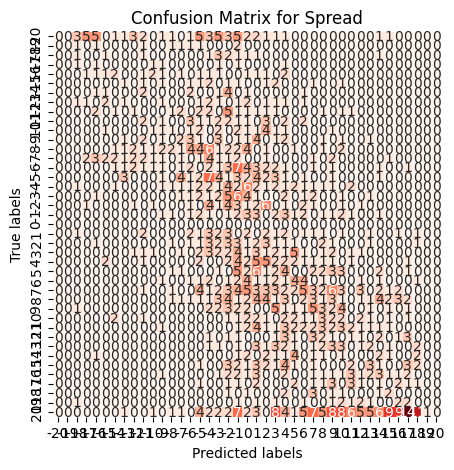

In [94]:
#look at spread predictions 
for model in range(3):
    model_name = f"no{model+1}_model.keras"
    print(model_name)
    model = tf.keras.models.load_model(model_name)
    predictions = model.predict(x_train_select)
    spread = predictions[0]
    putcome = predictions[1]
    #outcome
    predictions = np.argmax(putcome, axis = 1)
    print("accuracy: ", calculate_accuracy(np.argmax(y_train['outcome'],  axis =1), predictions))
    plt.figure(figsize=(5, 5))
    plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
    observed = np.argmax(y_train['outcome'],  axis =1)
    plt.hist(observed, alpha=0.5, label='obser')
    plt.legend()
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of winner Predicted vs Observed Values')
    plt.savefig(model_name+'outcome_hist.png')
    plt.show()
    plt.figure(figsize=(5, 5))
    cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
    cm.plot()
    plt.savefig(model_name+'outcome_cm.png')
    plt.show()
     
    #spread 
    print("accuracy: ", calculate_accuracy(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int)))
    plt.figure(figsize=(5, 5))
    plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
    plt.hist(y_train['spread'], bins=40, label='Observed', alpha=0.5)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of spread Predicted vs Observed Values')
    plt.legend()
    plt.savefig(model_name+'_spread_hist.png')
    plt.show()
     
    plt.figure(figsize=(5, 5))
    cm_spread = confusion_matrix(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int))
    sns.heatmap(cm_spread, cmap='Reds', annot=True, fmt='d', cbar=False)
    plt.xticks(ticks=np.arange(41) + 0.5, labels=np.arange(-20, 21))
    plt.yticks(ticks=np.arange(41) + 0.5, labels=np.arange(-20, 21))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for Spread')
    plt.savefig(model_name + '_spread_cm.png')
    plt.show()

### Results

The MeanSquaredError loss function paired with both softplus and softmax activation functions achieved moderate validation losses, but the MeanAbsoluteError with softplus activation surfaced as more effective, significantly lowering the validation loss and achieving the highest validation accuracy. However, the Huber loss paired with the softplus activation function outperformed others, achieving the lowest validation loss overall, indicating its robustness to outliers and effectiveness for this particular model. While the Huber loss with softmax activation yielded similar results, the outlier high losses in some configurations with the Huber loss suggest sensitivity to certain network settings or data conditions.

In [95]:
tf.keras.models.load_model("no3_model.keras").save("best_tuned_model.keras")

## Experiment 10 -- Examining the Genralizability of the Model and Effects of Various Number of Training Seasons.

In [105]:
# Model evaluation data
seasons = ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
results = {}

# Iterate over each test season
for test_season_index, test_season in enumerate(seasons[1:], start=1): 
    print(test_season_index, test_season)
    results[test_season] = {}
    x_test, y_test = pre_process_binary(test_season, top_n=8, subset=True)
    x_test = select_features(x_test)
    # Iterate over the possible number of training seasons for the current test season
    for train_season_index in range(0, test_season_index):  # From maximum to minimum training seasons
        train_seasons = seasons[train_season_index :test_season_index]  # Select training seasons dynamically
        print(train_seasons)
        results[test_season][len(train_seasons)]={}
        x_train_combo = {}
        y_train_combo = {}
        for this_season in train_seasons:
            x_train, y_train = pre_process_binary(this_season, top_n=8, subset=True)
            x_train = select_features(x_train)
    
        try:
            for key in x_train:
                x_train_combo[key] = tf.concat([x_train_combo[key], x_train[key]], axis=0)
        except:
            x_train_combo = x_train
        try:
            for key in y_train:
                y_train_combo[key] = tf.concat([y_train_combo[key], y_train[key]], axis=0)
        except:
            y_train_combo = y_train
 
        # # Train the model
        model = model_hp_testing(x_train_combo, y_train_combo, "model_name", tf.keras.losses.Huber(delta=0.5), "mean_squared_error", "Nadam", "tanh", tf.keras.activations.softplus)
        model.fit(x_train_combo, y_train_combo)
        
        # # Make predictions
        predictions = model.predict(x_test, verbose=0)
        spread = predictions[0]
        outcome = predictions[1]
        results[test_season][len(train_seasons)]['outcome'] = calculate_accuracy(np.argmax(y_test['outcome'], axis=1), np.argmax(outcome, axis=1))
        results[test_season][len(train_seasons)]['spread'] = calculate_accuracy(y_test['spread'], np.round(spread).astype(int))

1 2016-17
['2015-16']
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.9262 - outcome_accuracy: 0.5483 - spread_root_mean_squared_error: 11.1740
2 2017-18
['2015-16', '2016-17']
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1188 - outcome_accuracy: 0.5406 - spread_root_mean_squared_error: 11.6459
['2016-17']
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.0632 - outcome_accuracy: 0.5632 - spread_root_mean_squared_error: 11.6072
3 2018-19
['2015-16', '2016-17', '2017-18']
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2442 - outcome_accuracy: 0.5690 - spread_root_mean_squared_error: 11.9185
['2016-17', '2017-18']
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.0843 - outcome_accuracy: 0.5879 - spread_root_mean_squared_error: 11.6176
['2017-18']
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2504 - outcome_accuracy: 0.5092 - spread_root_mean_squared_error: 11.8836
4 2019-20
['2015-16', '2016-17', '2017-18', '2018-19']
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4193 - outc

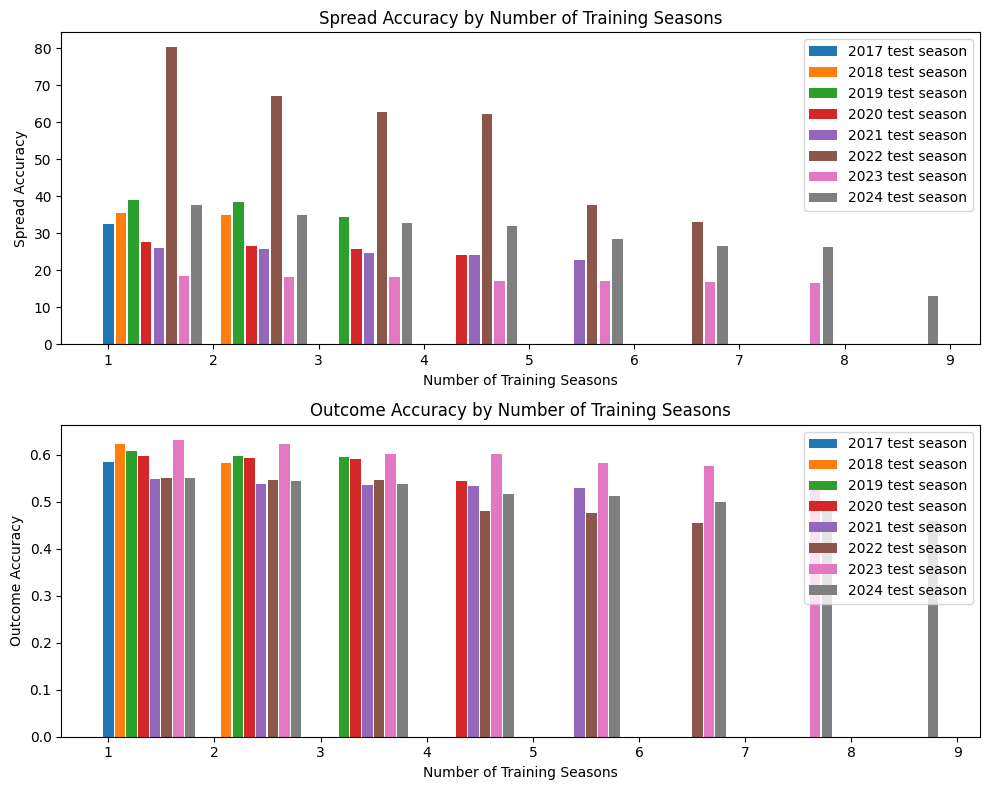

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionary for storing data
num_seasons_dict = {}
for i in range(1, 9):
    num_seasons_dict[i] = {}
    num_seasons_dict[i]['spread'] = []
    num_seasons_dict[i]['outcome'] = []

# Populate data
for test_season, season_data in results.items():
    for num_seasons, values in season_data.items():
        num_seasons_dict[num_seasons]['spread'].append(values['spread'])
        num_seasons_dict[num_seasons]['outcome'].append(values['outcome'])

# Pad with zeros
for key in num_seasons_dict:
    num_seasons_dict[key]['spread'] = [0] * (8 - len(num_seasons_dict[key]['spread'])) + num_seasons_dict[key]['spread']
    num_seasons_dict[key]['outcome'] = [0] * (8 - len(num_seasons_dict[key]['outcome'])) + num_seasons_dict[key]['outcome']

# Convert to numpy arrays
spread = np.array([num_seasons_dict[i]['spread'] for i in range(1, 9)])
outcome = np.array([num_seasons_dict[i]['outcome'] for i in range(1, 9)])

spread = np.sort(spread, axis=0)[::-1]
outcome = np.sort(outcome, axis=0)[::-1]

# Bar plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot spread accuracy
for i in range(spread.shape[1]):
    ax1.bar(np.arange(1, 9) + i * 0.12, spread[:, i], width=0.1, label=f'{i+2017} test season')

ax1.set_title('Spread Accuracy by Number of Training Seasons')
ax1.set_xlabel('Number of Training Seasons')
ax1.set_ylabel('Spread Accuracy')
ax1.legend()
ax1.set_title('Spread Accuracy by Number of Training Seasons')
ax1.set_xlabel('Number of Training Seasons')
ax1.set_ylabel('Spread Accuracy')
ax1.legend()

# Plot outcome accuracy
for i in range(outcome.shape[1]):
    ax2.bar(np.arange(1, 9) + i * 0.11, outcome[:, i], width=0.1, label=f'{i+2017} test season')

ax2.set_title('Spread Accuracy by Number of Training Seasons')
ax2.set_xlabel('Number of Training Seasons')
ax2.set_ylabel('Spread Accuracy')
ax2.legend()
ax2.set_title('Outcome Accuracy by Number of Training Seasons')
ax2.set_xlabel('Number of Training Seasons')
ax2.set_ylabel('Outcome Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


### Results

For our last experiment on combatting overfitting, we investigated the impact of varying amounts of training data on our model's performance. We experimented with incorporating additional previous NBA seasons to train the model, analyzing each season in the dataset after the 2014-15 NBA season. Our analysis revealed that spread accuracy showed significant variation across seasons, with the model's accuracy on test data slightly decreasing as more seasons were included in the training data.

In terms of outcome accuracies, the number of seasons used for training did not strongly influence the model's performance. Outcome Accuracy starts off relatively strong but does not significantly improve with more training, instead showing a tendency to plateau or slightly decline. This suggests that increased training does not consistently enhance predictive accuracy and that there may be an optimal point of training efficacy, beyond which the model's performance does not significantly progress or may even deteriorate. An interesting finding was that using four seasons of training data resulted in similar performance to using only one season, although still inferior results to other approaches.



In [98]:
# model evaluation data 
seasons = ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'] 
results ={}

for train_season in seasons:
    results[train_season] = {}
    print('\n', train_season)
    x_train, y_train= pre_process_binary(train_season,top_n=8, subset = True)
    x_train = select_features(x_train)
    for test_season in seasons:
        results[train_season][test_season] = {}
        print('\n', test_season)
        x_test, y_test= pre_process_binary(test_season, top_n=8, subset = True)
        x_test = select_features(x_test)
        model = model_hp_testing(x_train, y_train, "model_name", tf.keras.losses.Huber(delta=0.5), "mean_squared_error", "Nadam", "tanh", tf.keras.activations.softplus)
        model.fit(x_train, y_train)
        predictions = model.predict(x_test, verbose = 0)
        spread = predictions[0]
        outcome = predictions[1]
        results[train_season][test_season]['outcomepa'] = (np.argmax(outcome, axis = 1), np.argmax(y_test['outcome'], axis = 1))
        results[train_season][test_season]['spreadpa'] = (np.round(spread).astype(int), y_test['spread'])
        print(train_season, " ",  test_season) 


 2015-16

 2015-16
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.9886 - outcome_accuracy: 0.5799 - spread_root_mean_squared_error: 11.3908
2015-16   2015-16

 2016-17
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2120 - outcome_accuracy: 0.5913 - spread_root_mean_squared_error: 11.6964
2015-16   2016-17

 2017-18
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1609 - outcome_accuracy: 0.5762 - spread_root_mean_squared_error: 11.7883
2015-16   2017-18

 2018-19
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.0946 - outcome_accuracy: 0.5551 - spread_root_mean_squared_error: 11.5189
2015-16   2018-19

 2019-20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1010 - outcome_accuracy: 0.6025 - spread_root_mean_squared_error: 11.5839
2015-16   2019-20

 2020-21
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0742 - outcome_accuracy: 0.5756 - spread_root_mean_squared_error: 11.4077
2015-16   2020-21

 2021-22
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0815 - outcome_accuracy: 

# Testing on Next Season

In [99]:
x_test, y_test= pre_process_binary('2017-18',top_n=8, subset = True)
x_test_select= select_features(x_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
accuracy:  0.5747967479674797


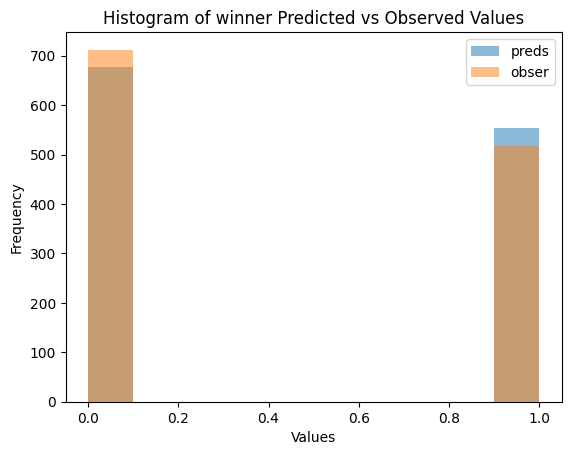

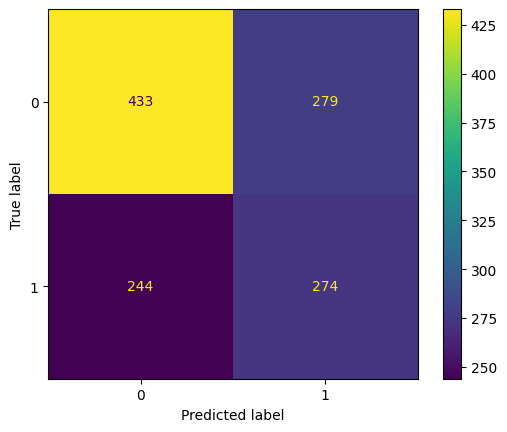

accuracy:  29.590243902439024


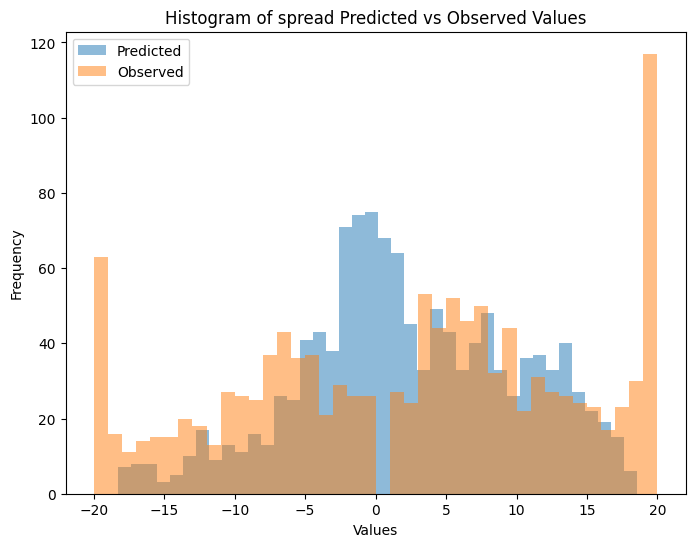

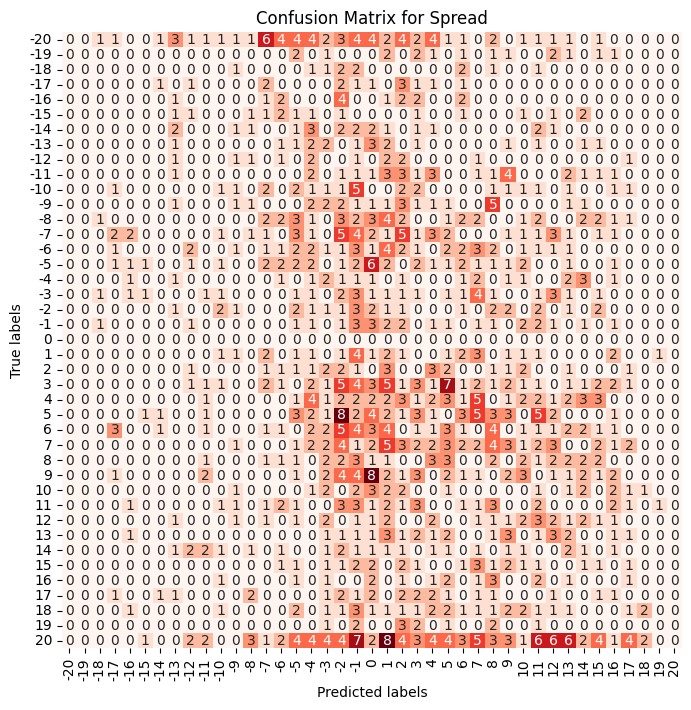

In [100]:
model = tf.keras.models.load_model("best_tuned_model.keras")
model_name = "best_tuned_model.keras"
predictions = model.predict(x_test_select)
spread = predictions[0]
putcome = predictions[1]
#outcome
predictions = np.argmax(putcome, axis = 1)
print("accuracy: ", calculate_accuracy(np.argmax(y_test['outcome'],  axis =1), predictions))
plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
observed = np.argmax(y_test['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.savefig(model_name+'outcome_hist.png')
plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.savefig(model_name+'outcome_cm.png')
plt.show()
 
#spread 
print("accuracy: ", calculate_accuracy(np.clip(y_test['spread'], -20, 20), np.round(spread).astype(int)))
plt.figure(figsize=(8, 6))
plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_test['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.savefig(model_name+'_spread_hist.png')
plt.show()
 
plt.figure(figsize=(8, 8))
cm_spread = confusion_matrix(np.clip(y_test['spread'], -20, 20), np.round(spread).astype(int))
sns.heatmap(cm_spread, cmap='Reds', annot=True, fmt='d', cbar=False)
plt.xticks(ticks=np.arange(41) + 0.5, labels=np.arange(-20, 21))
plt.yticks(ticks=np.arange(41) + 0.5, labels=np.arange(-20, 21))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Spread')
plt.savefig(model_name + '_spread_cm.png')
plt.show()

# Current Season Predictions 

In [101]:
# model evaluation data 
seasons = ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', ] 

train_season = '2022-23'
x_train, y_train= pre_process_binary(train_season, top_n=8, subset = True)
x_train = select_features(x_train)
test_season = '2023-24'
x_test, y_test= pre_process_binary(test_season, top_n=8, subset = True)
x_test = select_features(x_test)
model = model_hp_testing(x_train, y_train, "model_2024", tf.keras.losses.Huber(delta=0.5), "mean_squared_error", "Nadam", "tanh", tf.keras.activations.softplus)
model.fit(x_train, y_train)
print("evaluation")
model.evaluate(x_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2140 - outcome_accuracy: 0.5150 - spread_root_mean_squared_error: 11.7919
evaluation
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1199 - outcome_accuracy: 0.5053 - spread_root_mean_squared_error: 13.7382  


[5.769896984100342, 0.5435759425163269, 13.163330078125]

## Conclusion

Our accuracy for entirely new data is better than our baseline goal of 54.17 for outcome accuracy and 12.48% for the spread accuracy. When tested on 2023-2024 data, we saw an outcome accuracy of 57.47% and 29.59% for the spread. While this is still short of our "profitability goals" we outlined in the project proposal, this still provides valuable insights into sports betting and oddsmaking.

In the end, the model still shows signs of overfitting despite increasing the amount of training data provided. We suspect that improving the quality of the training data, either by adding more features or through feature engineering, will have postive impacts on model results.

For future exploration, our team would want to look at reinforcement learning options to help reduce the zero-centered outcomes in the spread. Another approach would be to seperate the spread and the outcome into two models, and aggregate the results.